In [1]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import os
import gc
from copy import deepcopy
from scripts import utils, features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


In [3]:
DATA_DIR = "../data/image-matching-challenge-2025"
VGGT_DIR = "weights/vggt-1B"
OUTPUT_FILE = "train_predictions.csv"
FEATURES_DIR = "vggt_features/last_features"
# Configure dataset filtering 
DATASETS_FILTER = [
    # New 2025 datasets
    # "amy_gardens",
    "ETs",
    "fbk_vineyard",
    "stairs",
    # Data from IMC 2023 and 2024.
    'imc2024_dioscuri_baalshamin',
    'imc2023_theather_imc2024_church',
    # 'imc2023_heritage',
    # 'imc2023_haiper',
    'imc2024_lizard_pond',
    # Crowdsourced PhotoTourism data.
    # 'pt_stpeters_stpauls',
    # 'pt_brandenburg_british_buckingham',
    'pt_piazzasanmarco_grandplace',
    'pt_sacrecoeur_trevi_tajmahal',
]

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

In [5]:
# Load the dataset
samples = utils.dataset.load_dataset(DATA_DIR)

for dataset in samples:
    print(f'Dataset "{dataset}" -> num_images={len(samples[dataset])}')

Dataset "imc2023_haiper" -> num_images=54
Dataset "imc2023_heritage" -> num_images=209
Dataset "imc2023_theather_imc2024_church" -> num_images=76
Dataset "imc2024_dioscuri_baalshamin" -> num_images=138
Dataset "imc2024_lizard_pond" -> num_images=214
Dataset "pt_brandenburg_british_buckingham" -> num_images=225
Dataset "pt_piazzasanmarco_grandplace" -> num_images=168
Dataset "pt_sacrecoeur_trevi_tajmahal" -> num_images=225
Dataset "pt_stpeters_stpauls" -> num_images=200
Dataset "amy_gardens" -> num_images=200
Dataset "fbk_vineyard" -> num_images=163
Dataset "ETs" -> num_images=22
Dataset "stairs" -> num_images=51


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained(VGGT_DIR).to(device)

Loading weights from local directory


In [7]:
datasets = {}
for dataset in df['dataset'].unique():
    if DATASETS_FILTER and dataset not in DATASETS_FILTER:
        print(f'Skipping "{dataset}"')
        continue
    print(f'Processing "{dataset}"')
    datasets[dataset] = {}
    dataset_rows = df[df['dataset'] == dataset]
    dataset_rows = dataset_rows.sort_values(by='image')
    # sort dataset_rows by image
    features_dir = os.path.join(FEATURES_DIR, dataset)
    # get all files with .pt extension
    features_files = [f for f in os.listdir(features_dir) if f.endswith('.pt')]
    vggt_features = []
    for feature_file in features_files:
        feature_path = os.path.join(features_dir, feature_file)
        feature = torch.load(feature_path)[0]
        if feature.shape[1] != 1374:
            num_images, num_patches, num_channels = feature.shape
            register_tokens = feature[:, :5, :]
            patch_tokens = feature[:, 5:, :].reshape(num_images, -1, 37, num_channels).permute(0, 3, 1, 2)
            patch_tokens_interpolated = torch.nn.functional.interpolate(
                patch_tokens, size=(37, 37), mode='bilinear', align_corners=False
            ).permute(0, 2, 3, 1).reshape(num_images, -1, num_channels)
            feature = torch.cat((register_tokens, patch_tokens_interpolated), dim=1)
            assert feature.shape[1] == 1374, f"Feature shape mismatch: {feature.shape}"
        vggt_features.append(feature)
    vggt_features = torch.cat(vggt_features, dim=0)
    for scene in dataset_rows['scene'].unique():
        datasets[dataset][scene] = []
        scene_features = vggt_features[list(dataset_rows['scene'] == scene)]
        # index the features by scene_rows
        datasets[dataset][scene] = scene_features

Skipping "imc2023_haiper"
Skipping "imc2023_heritage"
Processing "imc2023_theather_imc2024_church"


/tmp/ipykernel_3153392/2768851403.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(feature_path)[0]


Processing "imc2024_dioscuri_baalshamin"
Processing "imc2024_lizard_pond"
Skipping "pt_brandenburg_british_buckingham"
Processing "pt_piazzasanmarco_grandplace"
Processing "pt_sacrecoeur_trevi_tajmahal"
Skipping "pt_stpeters_stpauls"
Skipping "amy_gardens"
Processing "fbk_vineyard"
Processing "ETs"
Processing "stairs"


In [8]:
all_vectors = {dataset_name: [] for dataset_name in datasets.keys()}
all_labels = {dataset_name: [] for dataset_name in datasets.keys()}
all_label_names = {dataset_name: [] for dataset_name in datasets.keys()}

for dataset_name, scenes in datasets.items():
    for cluster_id, (name, vectors) in enumerate(scenes.items()):
        all_vectors[dataset_name].extend([v.cpu().numpy() for v in vectors])
        all_labels[dataset_name].extend([cluster_id] * len(vectors))
        all_label_names[dataset_name].extend([name] * len(vectors))

In [9]:
def visualize_clusters_2d(features_2d, cluster_labels, all_label_names, algorithm):
        # Step 3: Prepare GT label color map
        gt_labels = all_label_names[dataset_name]  # Make sure this is aligned with image_features
        cluster_names = sorted(set(gt_labels))
        gt_palette = sns.color_palette("hls", len(cluster_names))
        gt_color_map = {name: gt_palette[i] for i, name in enumerate(cluster_names)}
        gt_colors = [gt_color_map[label] for label in gt_labels]

        # Step 4: Prepare prediction label color map
        unique_labels = sorted(set(cluster_labels))
        pred_palette = sns.color_palette("hls", len(unique_labels))
        pred_color_map = {label: pred_palette[i] for i, label in enumerate(unique_labels)}
        pred_colors = [pred_color_map[label] for label in cluster_labels]

        # ---- Plotting both subplots ----
        fig, axs = plt.subplots(1, 2, figsize=(18, 8))
        fig.suptitle(f"{algorithm} Clustering: {dataset_name}", fontsize=16)

        # --- Left: Prediction ---
        ax = axs[0]
        for label in unique_labels:
            indices = [i for i, l in enumerate(cluster_labels) if l == label]
            subset = features_2d[indices]
            ax.scatter(subset[:, 0], subset[:, 1],
                    c=[pred_color_map[label]],
                    label=f'Cluster {label}' if label != -1 else 'Outlier',
                    s=40, alpha=0.6, edgecolors='k')
        ax.set_title("Predicted Clusters")
        ax.set_xlabel("Axis 1")
        ax.set_ylabel("Axis 2")
        ax.legend(fontsize='small')

        # --- Right: Ground Truth ---
        ax = axs[1]
        for name in cluster_names:
            indices = [i for i, lbl in enumerate(gt_labels) if lbl == name]
            subset = features_2d[indices]
            ax.scatter(subset[:, 0], subset[:, 1],
                    c=[gt_color_map[name]],
                    label=name,
                    s=40, alpha=0.6, edgecolors='k')
        ax.set_title("Ground Truth Clusters")
        ax.set_xlabel("Axis 1")
        ax.set_ylabel("Axis 2")

        # GT Legend
        handles = [
            Line2D([0], [0], marker='o', color='w', label=label,
                markerfacecolor=gt_color_map[label], markersize=8, markeredgecolor='k')
            for label in cluster_names
        ]
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title='GT')

        plt.tight_layout()
        plt.show()

def visualize_clusters_3d(features_3d, cluster_labels, all_label_names, algorithm="TSNE"):

        gt_labels = all_label_names[dataset_name]
        df = pd.DataFrame({
            'x': features_3d[:, 0],
            'y': features_3d[:, 1],
            'z': features_3d[:, 2],
            'pred': cluster_labels.astype(str),
            'gt': gt_labels
        })

        # create a 1×2 subplot layout for 3D
        fig = make_subplots(
            rows=1, cols=2,
            specs=[[{'type': 'scene'}, {'type': 'scene'}]],
            subplot_titles=("Predicted Clusters", "Ground Truth")
        )

        # predicted clusters
        for lbl in df['pred'].unique():
            sub = df[df['pred'] == lbl]
            fig.add_trace(
                go.Scatter3d(
                    x=sub.x, y=sub.y, z=sub.z,
                    mode='markers',
                    name=f"Pred {lbl}",
                    marker=dict(size=4),
                    legendgroup=f"pred",
                ),
                row=1, col=1
            )

        # ground-truth clusters
        for name in df['gt'].unique():
            sub = df[df['gt'] == name]
            fig.add_trace(
                go.Scatter3d(
                    x=sub.x, y=sub.y, z=sub.z,
                    mode='markers',
                    name=name,
                    marker=dict(size=4),
                    legendgroup=f"gt",
                ),
                row=1, col=2
            )

        # tighten up the layout
        fig.update_layout(
            height=600, width=1200,
            title_text=f"Interactive 3D {algorithm} Clustering: {dataset_name}"
        )

        fig.show()

## Clustering

### 1st Register Token

In [10]:
first_register_token = 1
def first_register_token_pooling_function(x):
    return [image_feature[first_register_token, :] for image_feature in x]

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_theather_imc2024_church, Silhouette Score: 0.3483


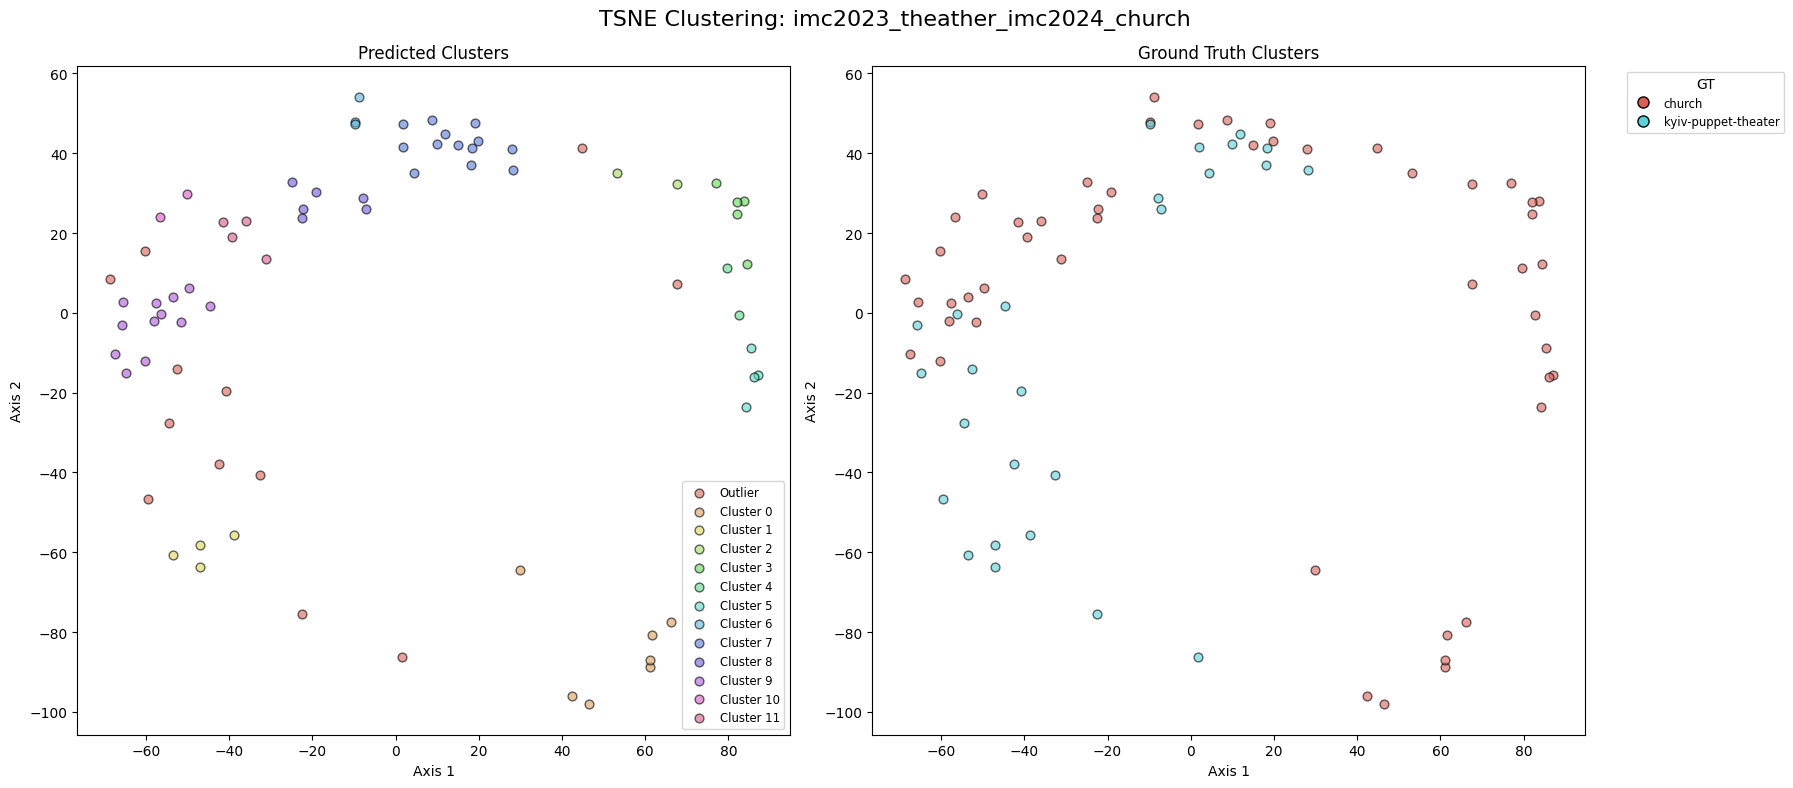

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_dioscuri_baalshamin, Silhouette Score: 0.2746


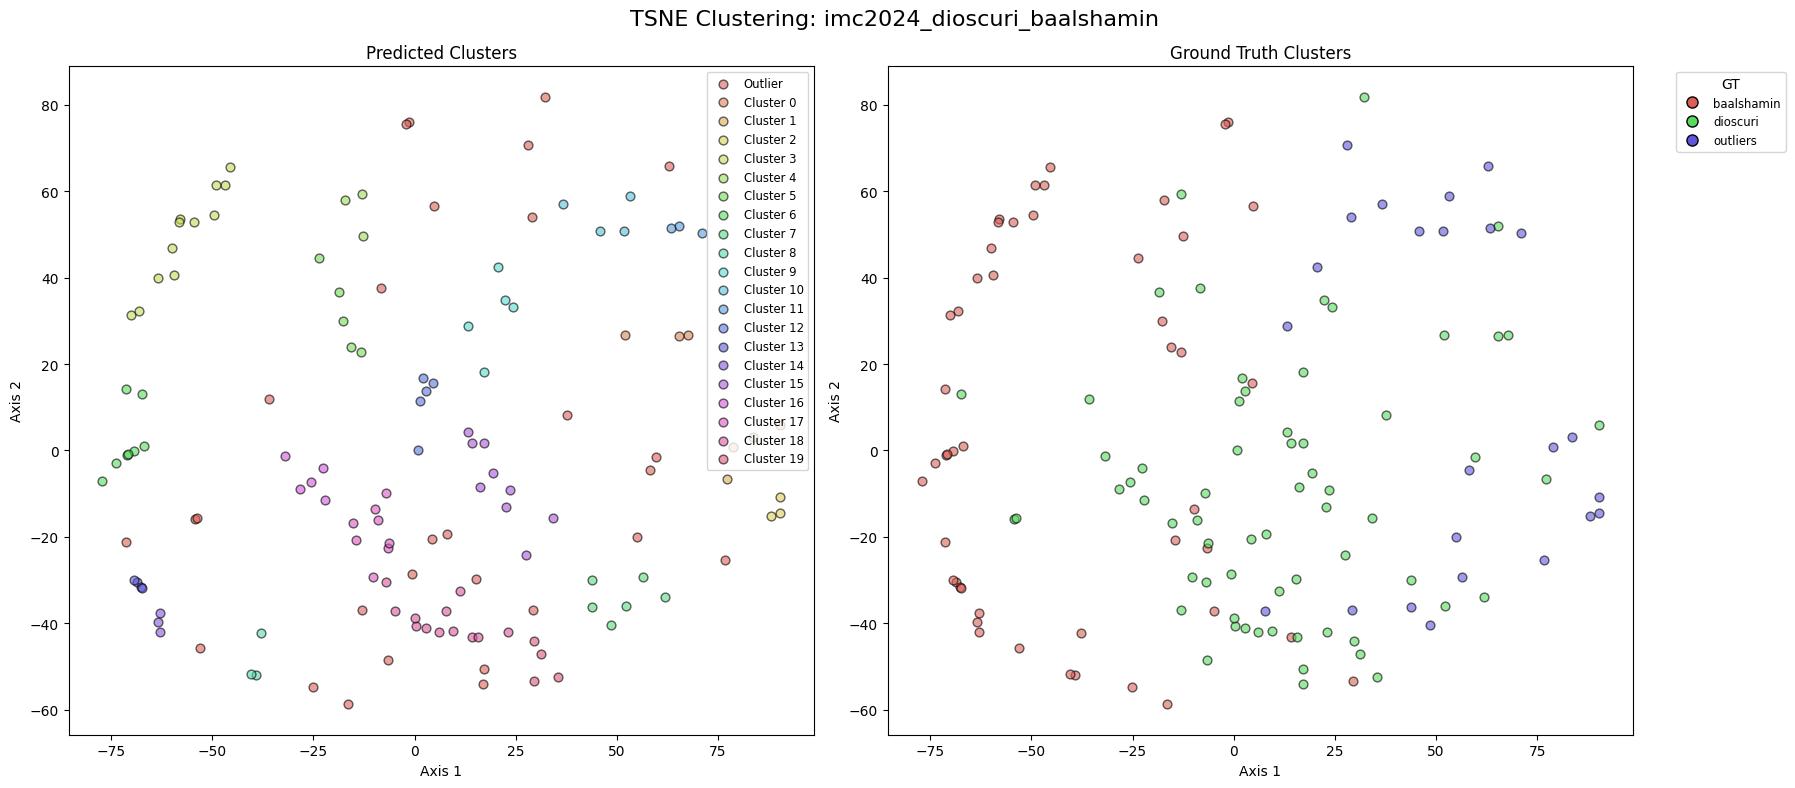

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_lizard_pond, Silhouette Score: 0.2317


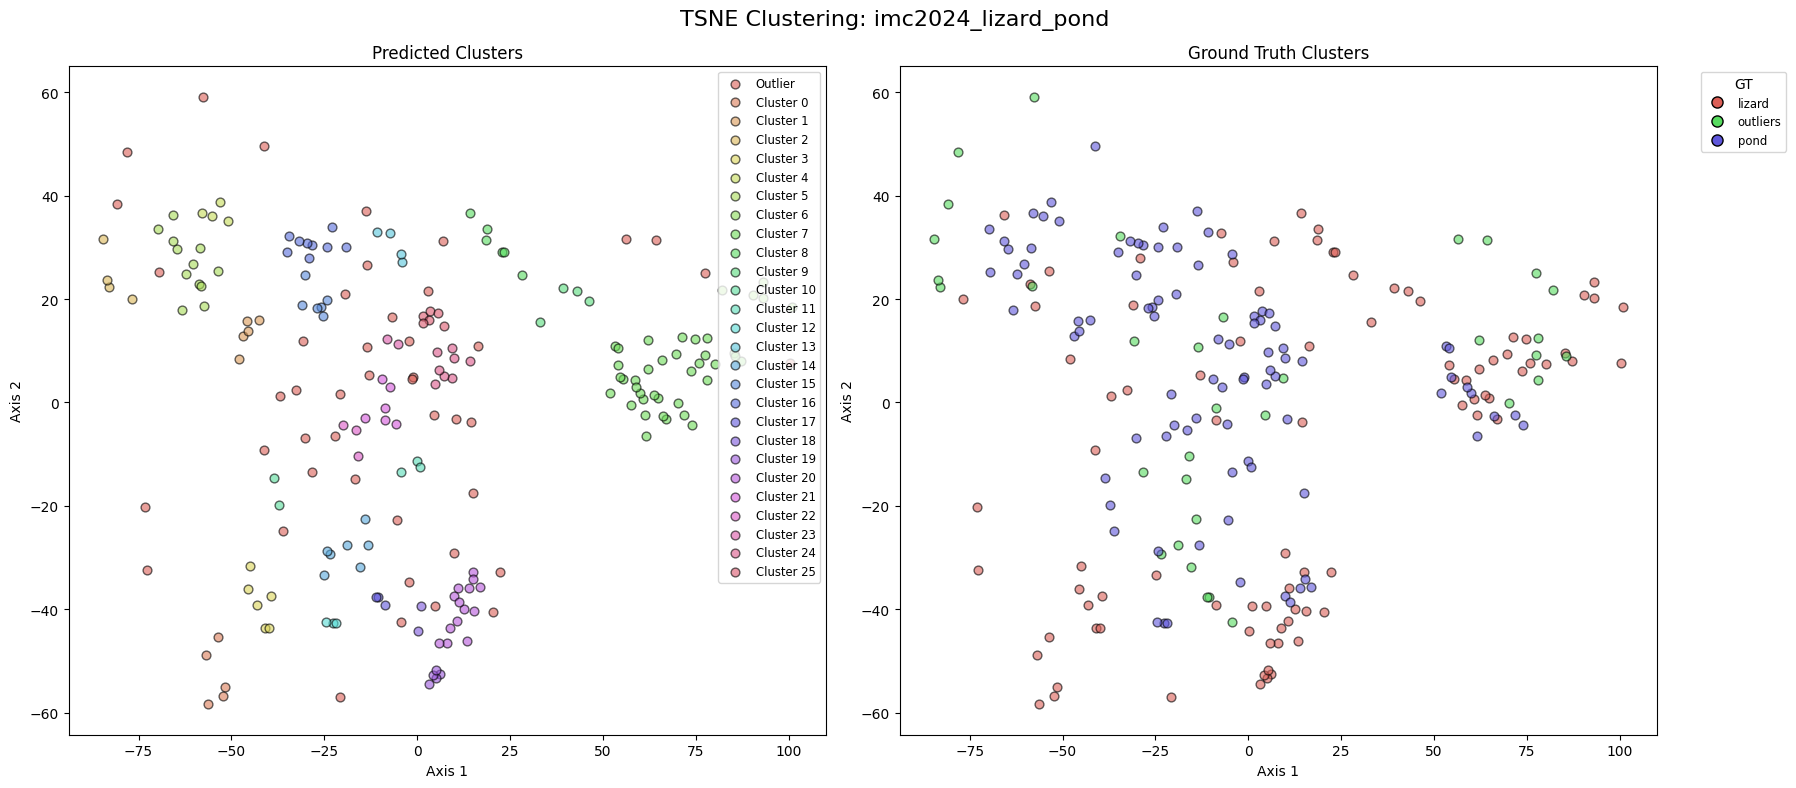

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_piazzasanmarco_grandplace, Silhouette Score: 0.1029


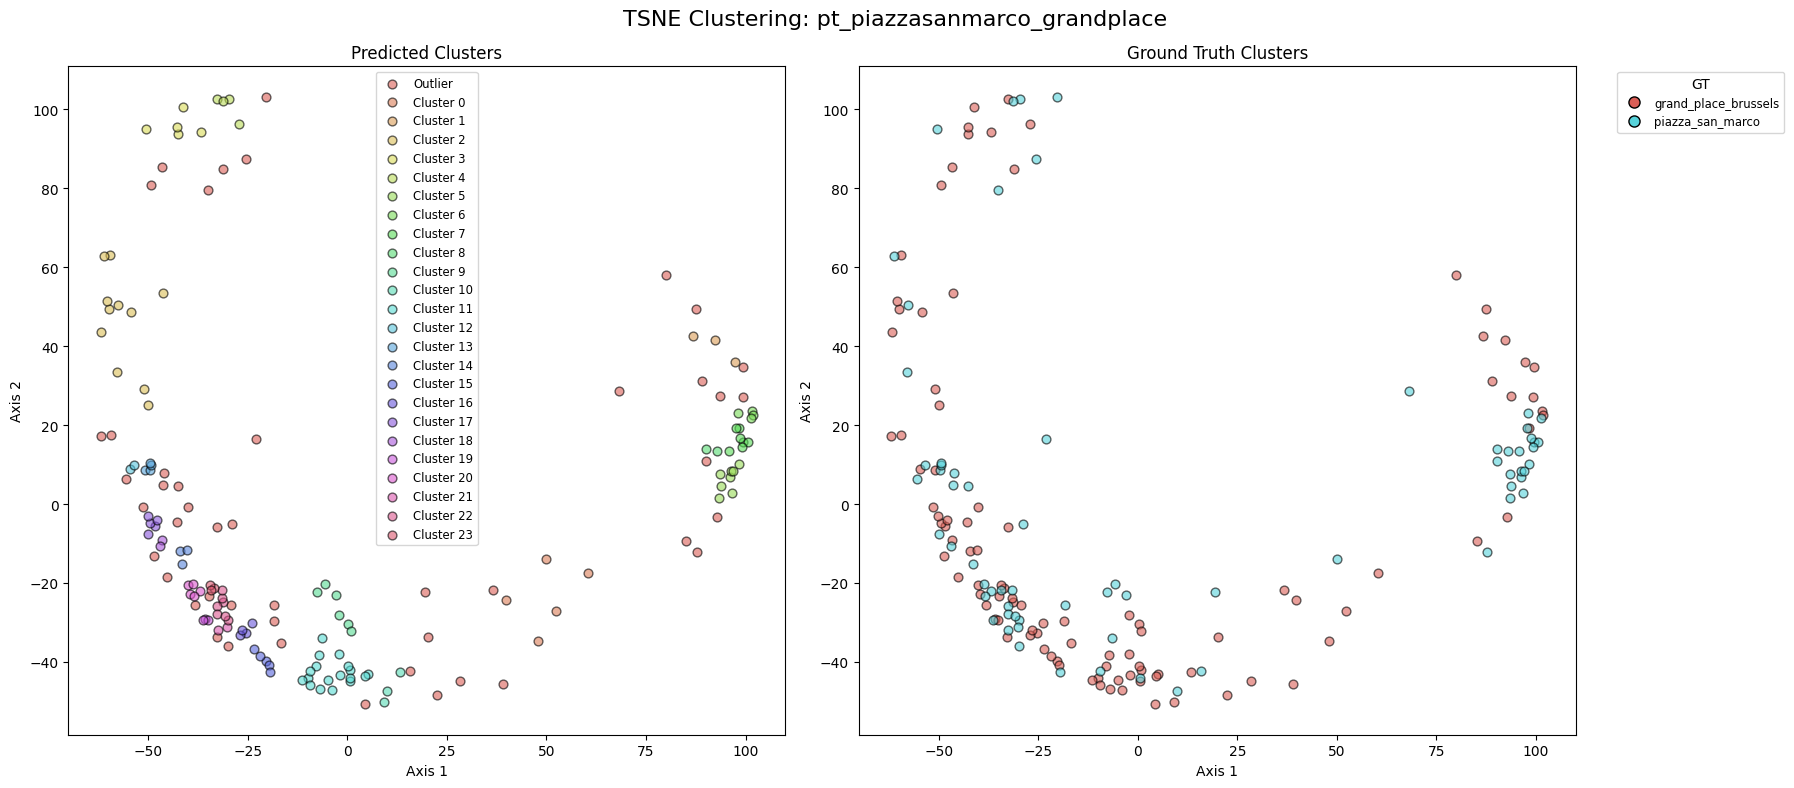

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_sacrecoeur_trevi_tajmahal, Silhouette Score: 0.0719


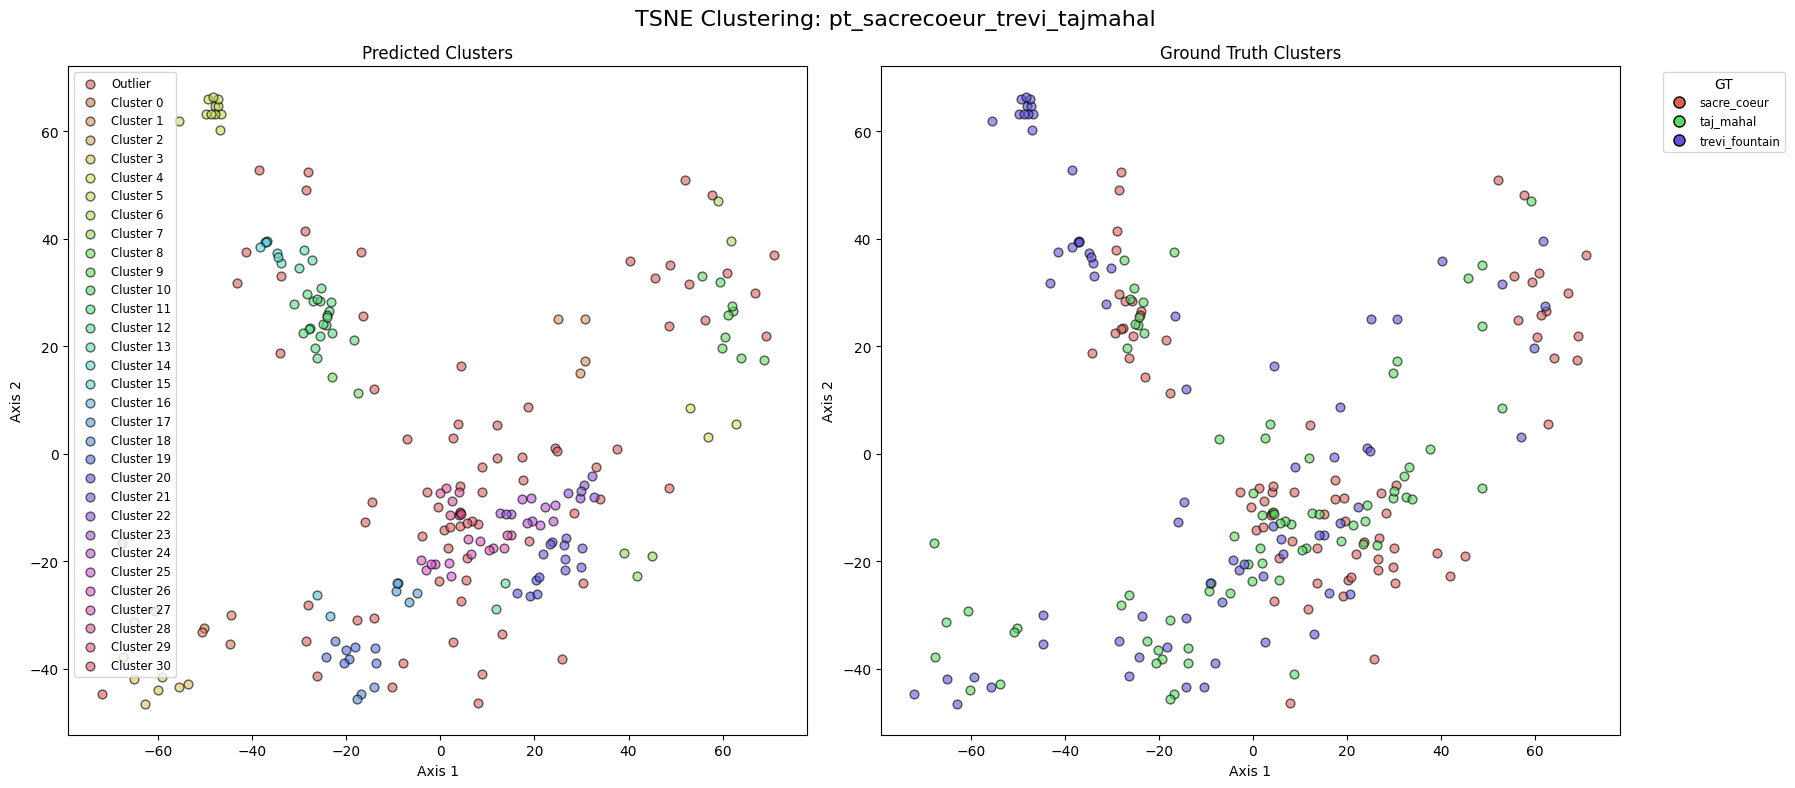

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: fbk_vineyard, Silhouette Score: 0.5260


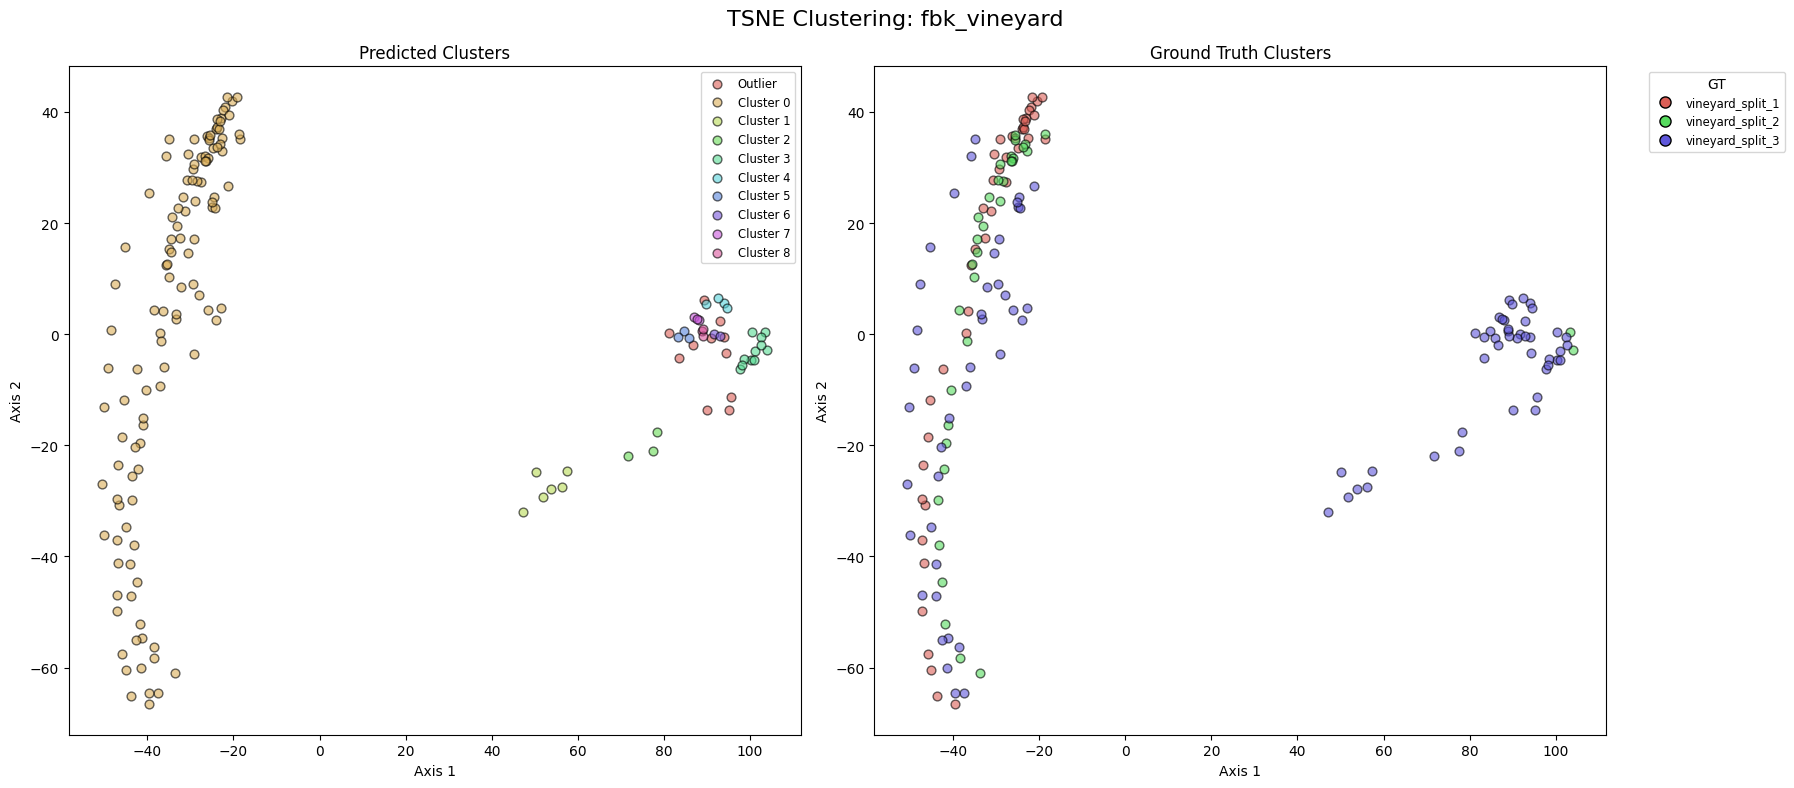

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: ETs, Silhouette Score: 0.6619


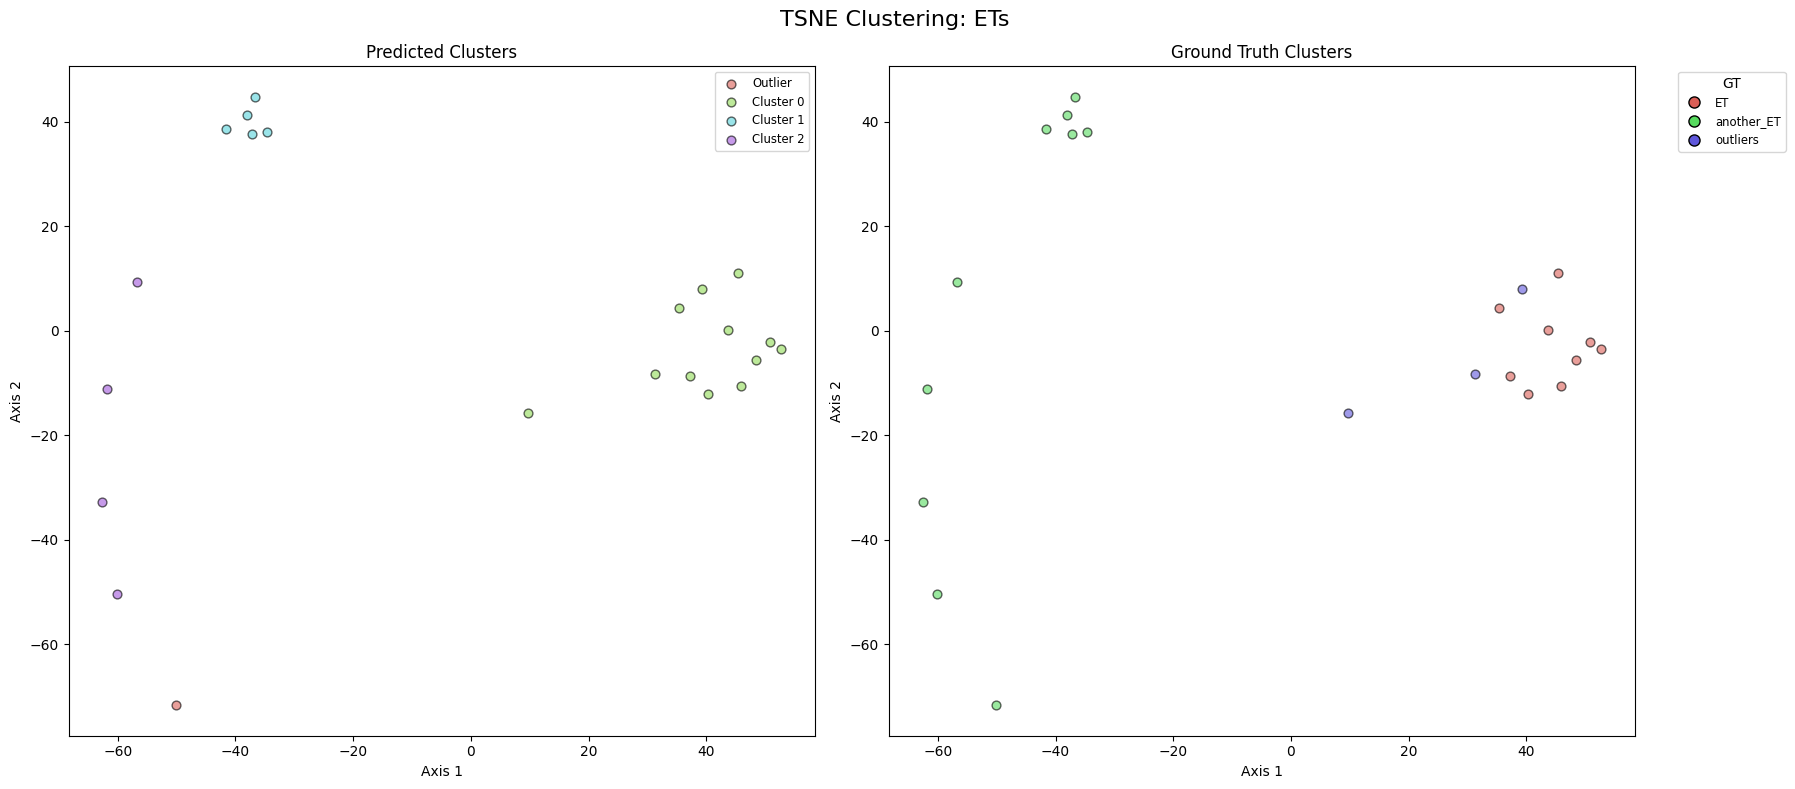

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: stairs, Silhouette Score: 0.1285


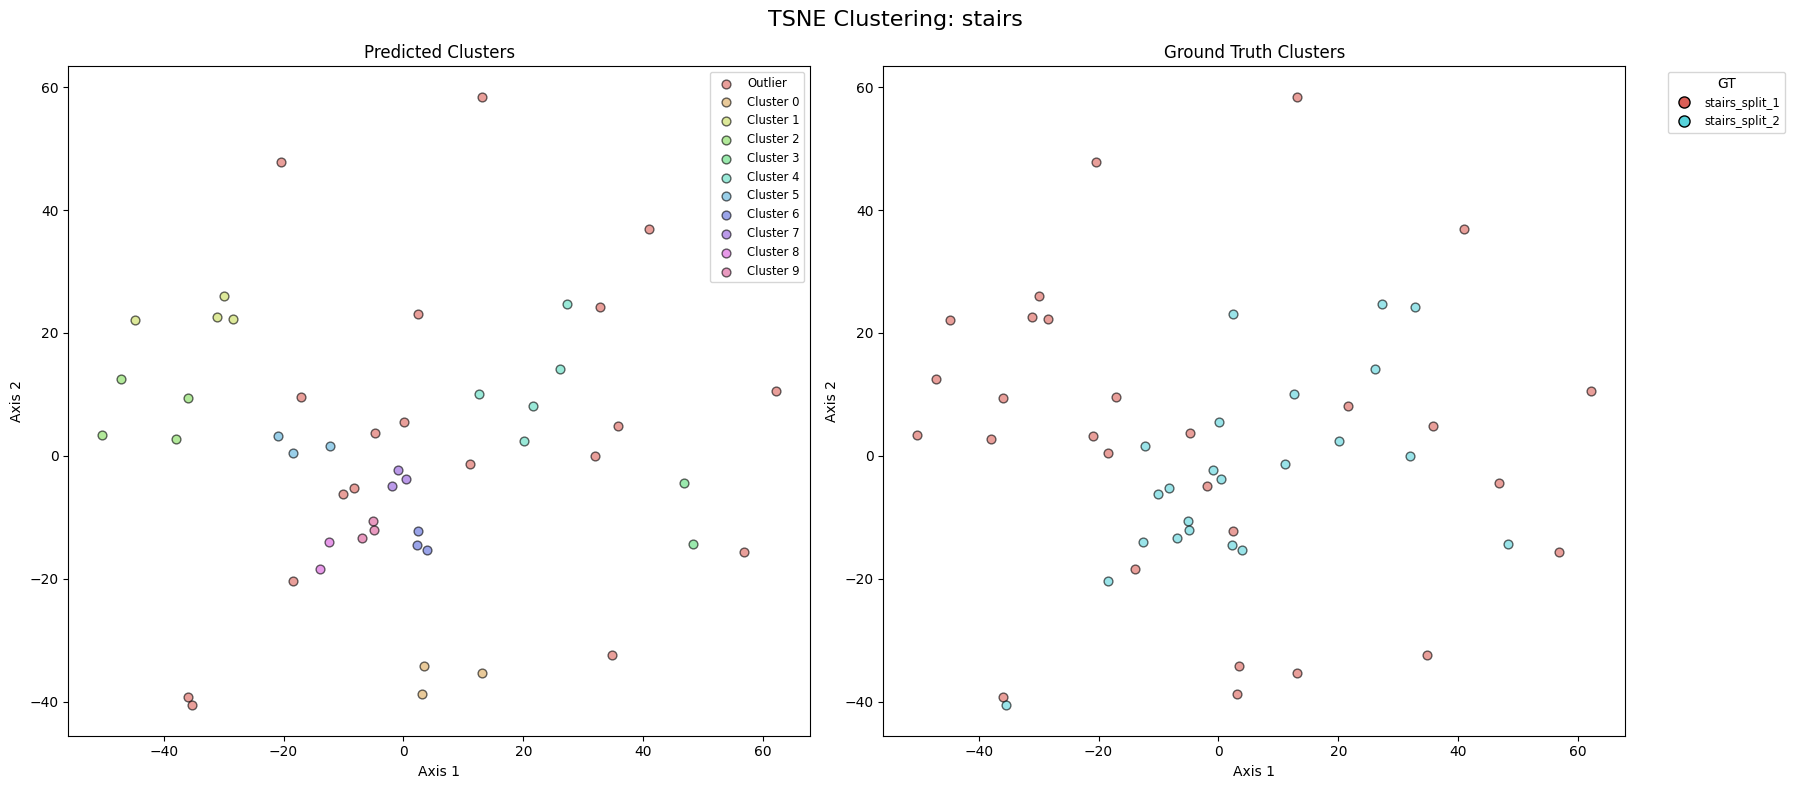

In [11]:
for dataset_name, image_features in all_vectors.items():
    # Step 1: t-SNE on features
    features_2d = features.extraction.feature_reducer(
            algorithm="PCA",
            features=np.vstack(first_register_token_pooling_function(image_features)),
            n_components=2,
            random_state=42,
            # perplexity=15,
        )

    # Step 2: Run HDBSCAN or any clustering on 2D features
    cluster_labels = features.clustering.dino_clusterer(
            algorithm="HDBSCAN",
            features=features_2d,
            scaler=None,
            min_cluster_size=2,
        )
    silhouette_avg = silhouette_score(features_2d, cluster_labels)
    print(f"Dataset: {dataset_name}, Silhouette Score: {silhouette_avg:.4f}")

    visualize_clusters_2d(
        features_2d,
        cluster_labels,
        all_label_names,
        algorithm="TSNE",
    )

### Camera Token

In [12]:
camera_token = 0
def camera_token_pooling_function(x):
    return [image_feature[camera_token, :] for image_feature in x]

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_theather_imc2024_church, Silhouette Score: 0.3704


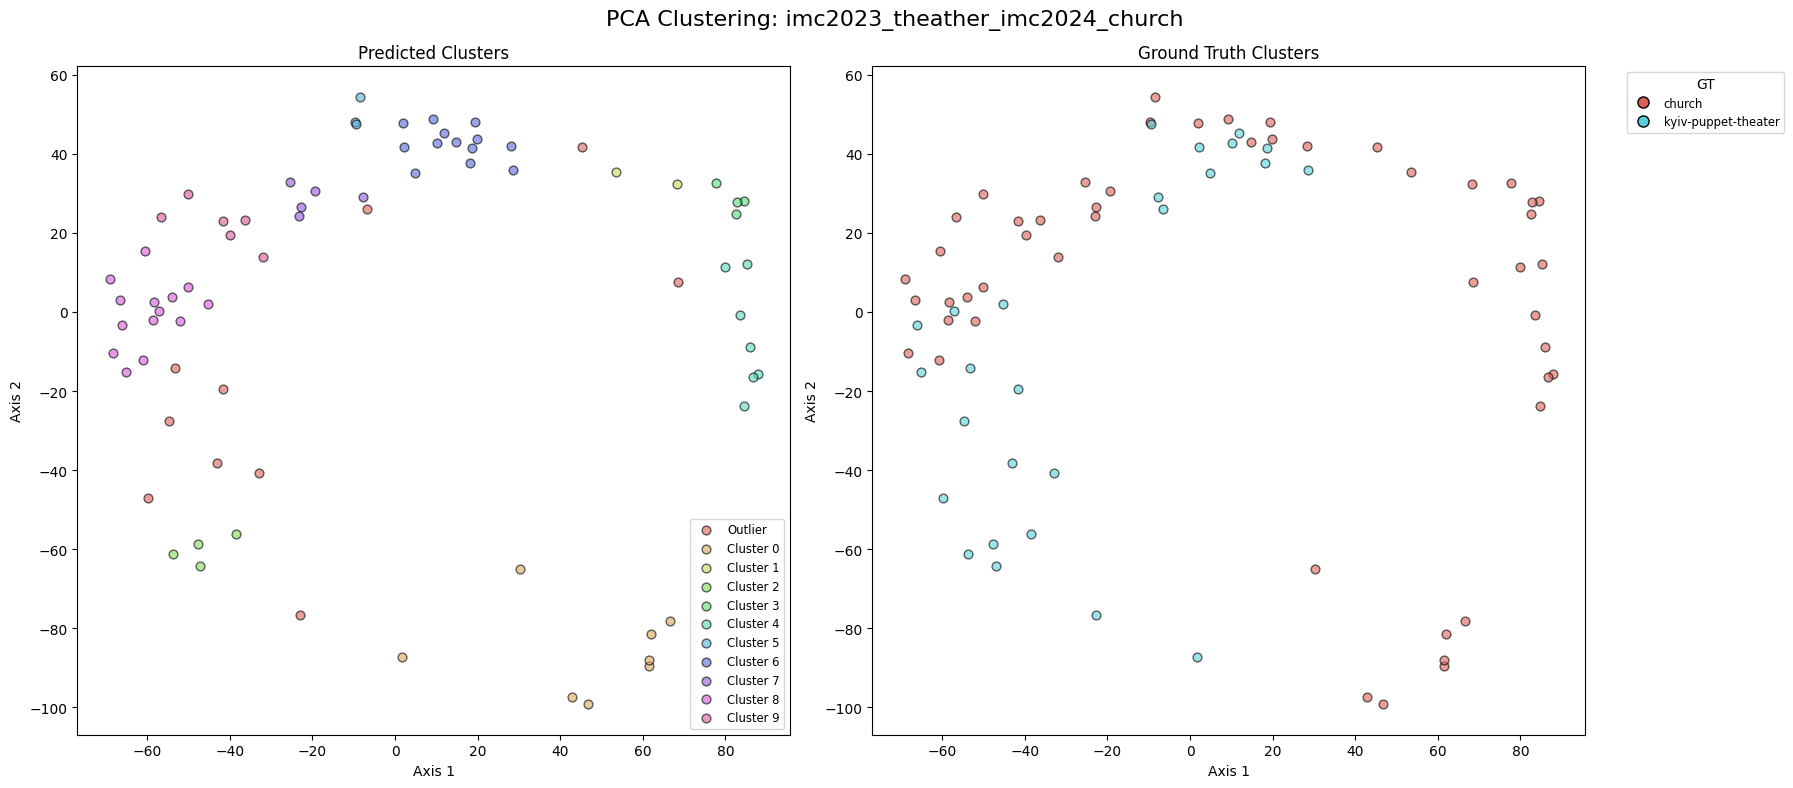

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_dioscuri_baalshamin, Silhouette Score: 0.2580


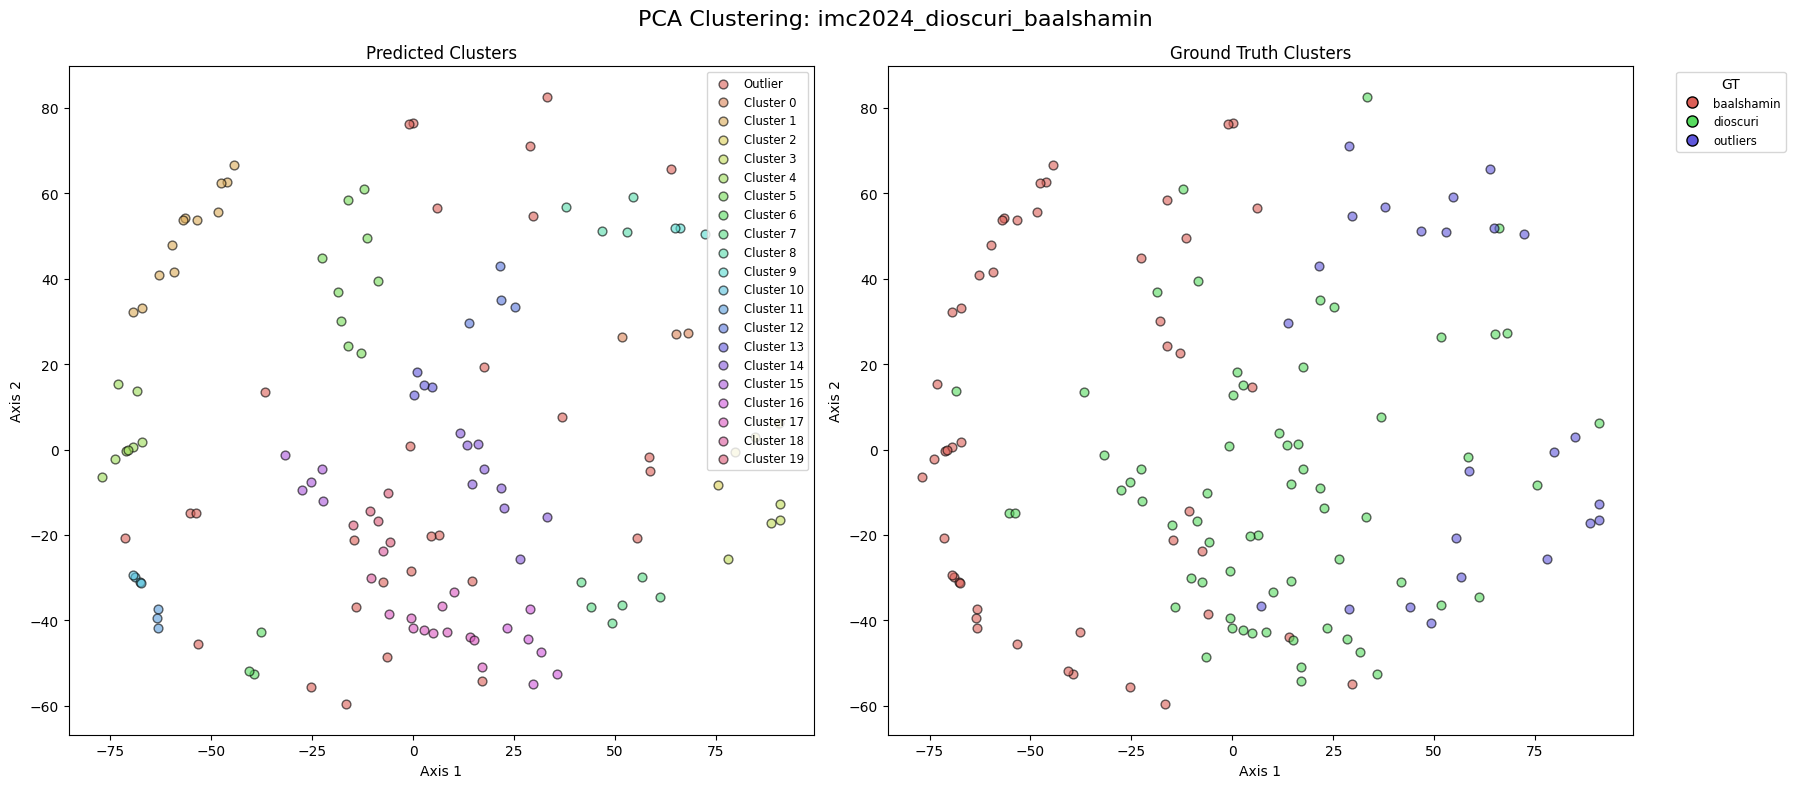

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_lizard_pond, Silhouette Score: 0.2386


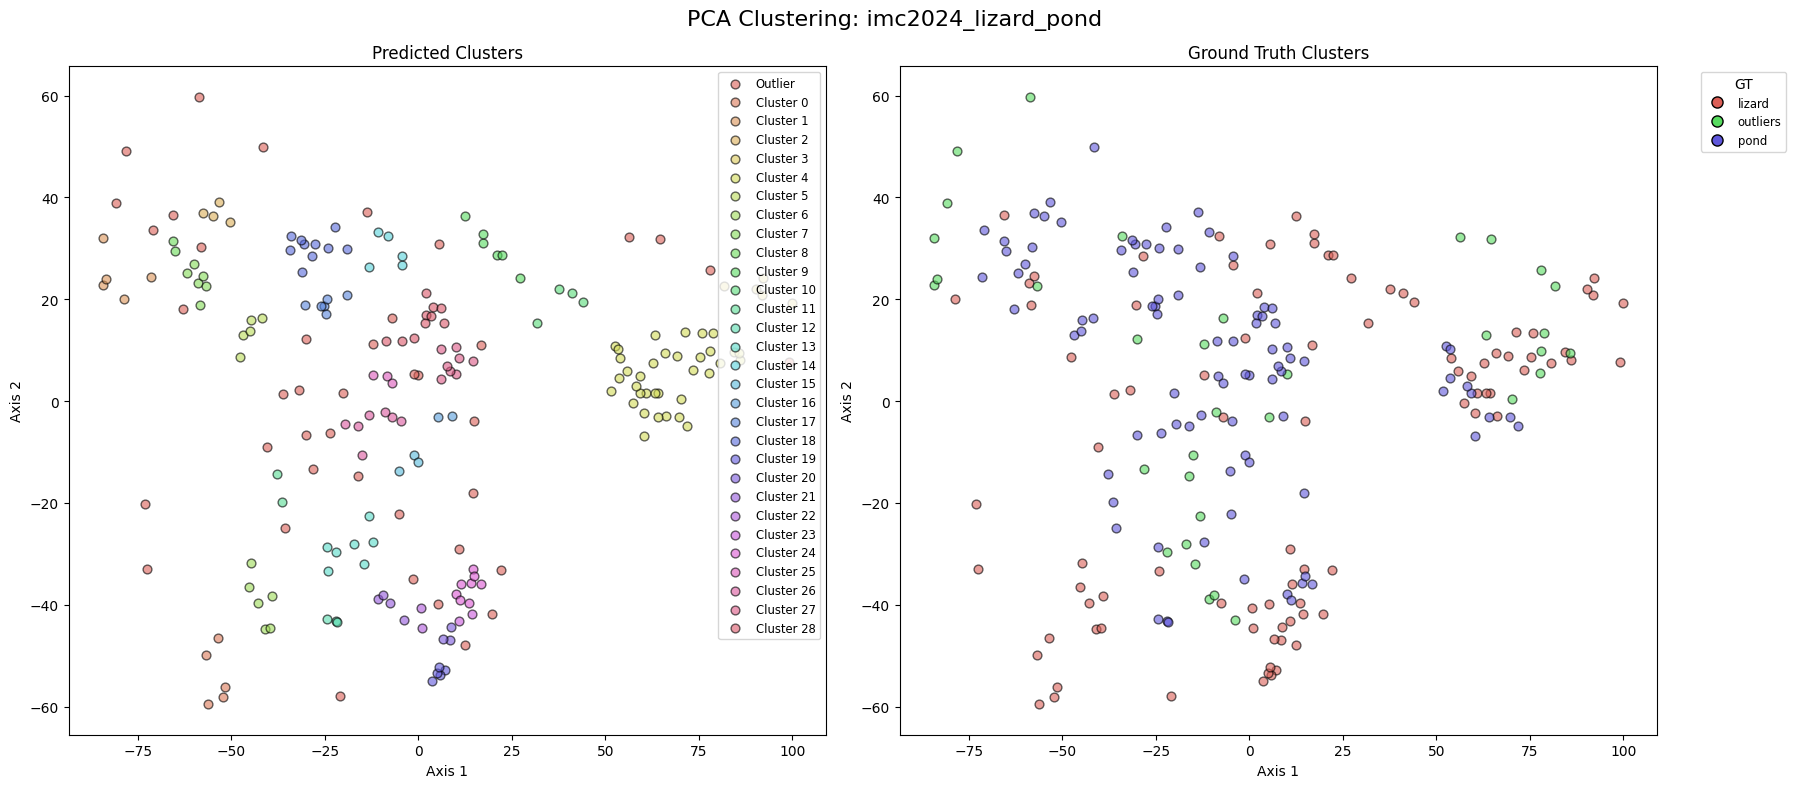

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_piazzasanmarco_grandplace, Silhouette Score: 0.1130


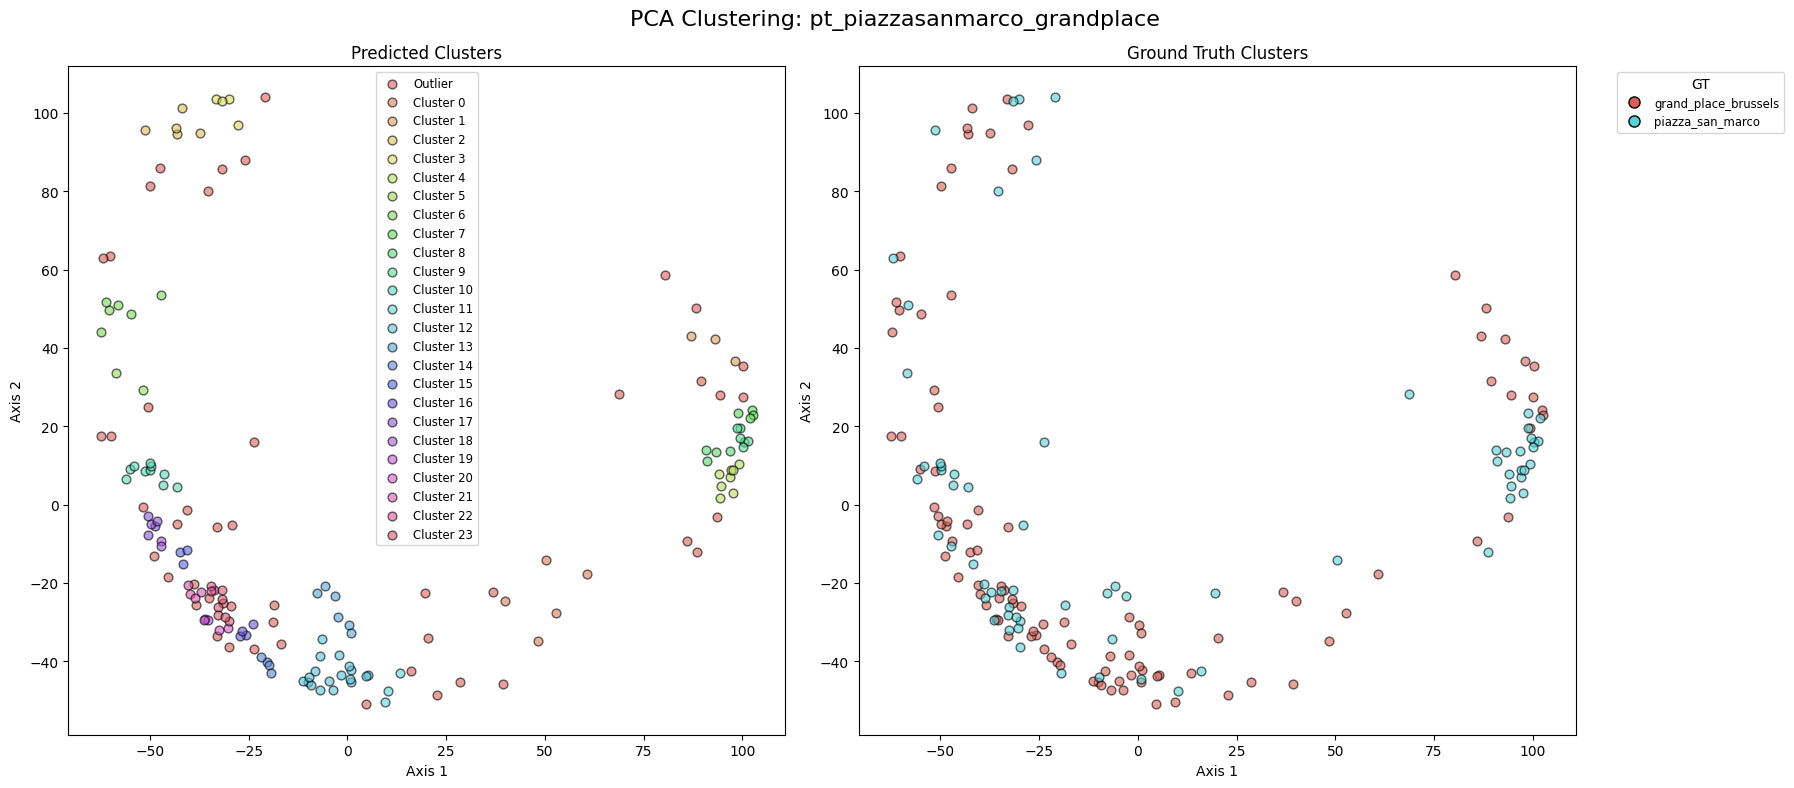

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_sacrecoeur_trevi_tajmahal, Silhouette Score: 0.0747


KeyboardInterrupt: 

In [13]:
for dataset_name, image_features in all_vectors.items():
    # Step 1: t-SNE on features
    features_2d = features.extraction.feature_reducer(
            algorithm="PCA",
            features=np.vstack(camera_token_pooling_function(image_features)),
            n_components=2,
            random_state=42,
            # perplexity=15,
        )

    # Step 2: Run HDBSCAN or any clustering on 2D features
    cluster_labels = features.clustering.dino_clusterer(
            algorithm="HDBSCAN",
            features=features_2d,
            scaler=None,
            min_cluster_size=2,
        )
    silhouette_avg = silhouette_score(features_2d, cluster_labels)
    print(f"Dataset: {dataset_name}, Silhouette Score: {silhouette_avg:.4f}")

    visualize_clusters_2d(
        features_2d,
        cluster_labels,
        all_label_names,
        algorithm="PCA",
    )

### Register Pool Token

In [ ]:
def register_token_pooling_function(x):
    return np.mean([image_feature[1:5, :] for image_feature in x], axis=1)

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_theather_imc2024_church, Silhouette Score: 0.3475


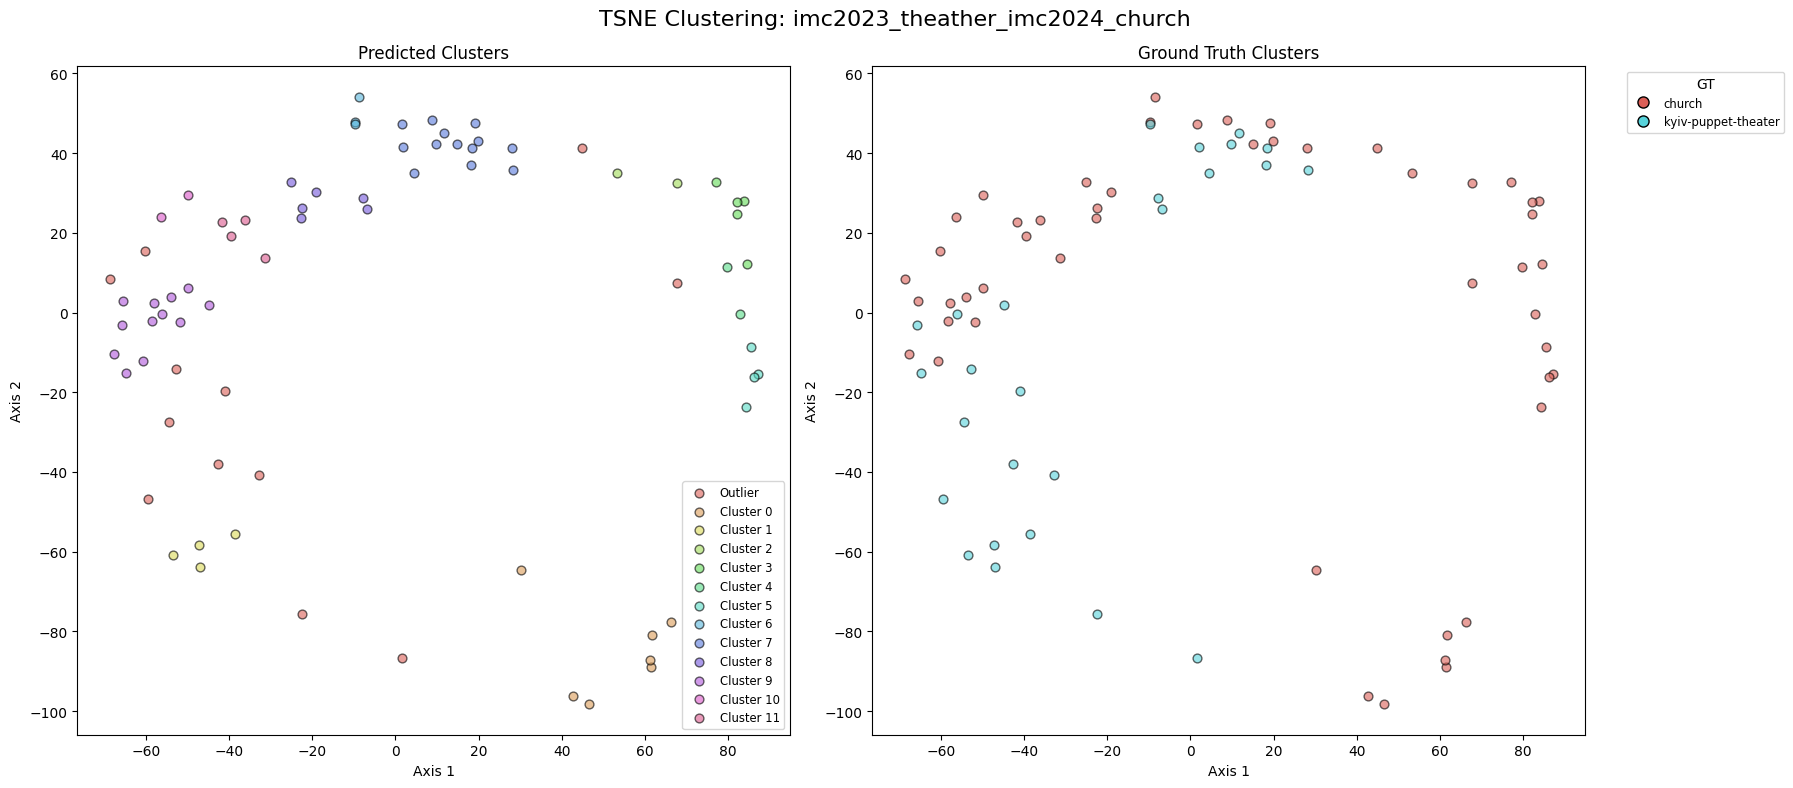

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_dioscuri_baalshamin, Silhouette Score: 0.2707


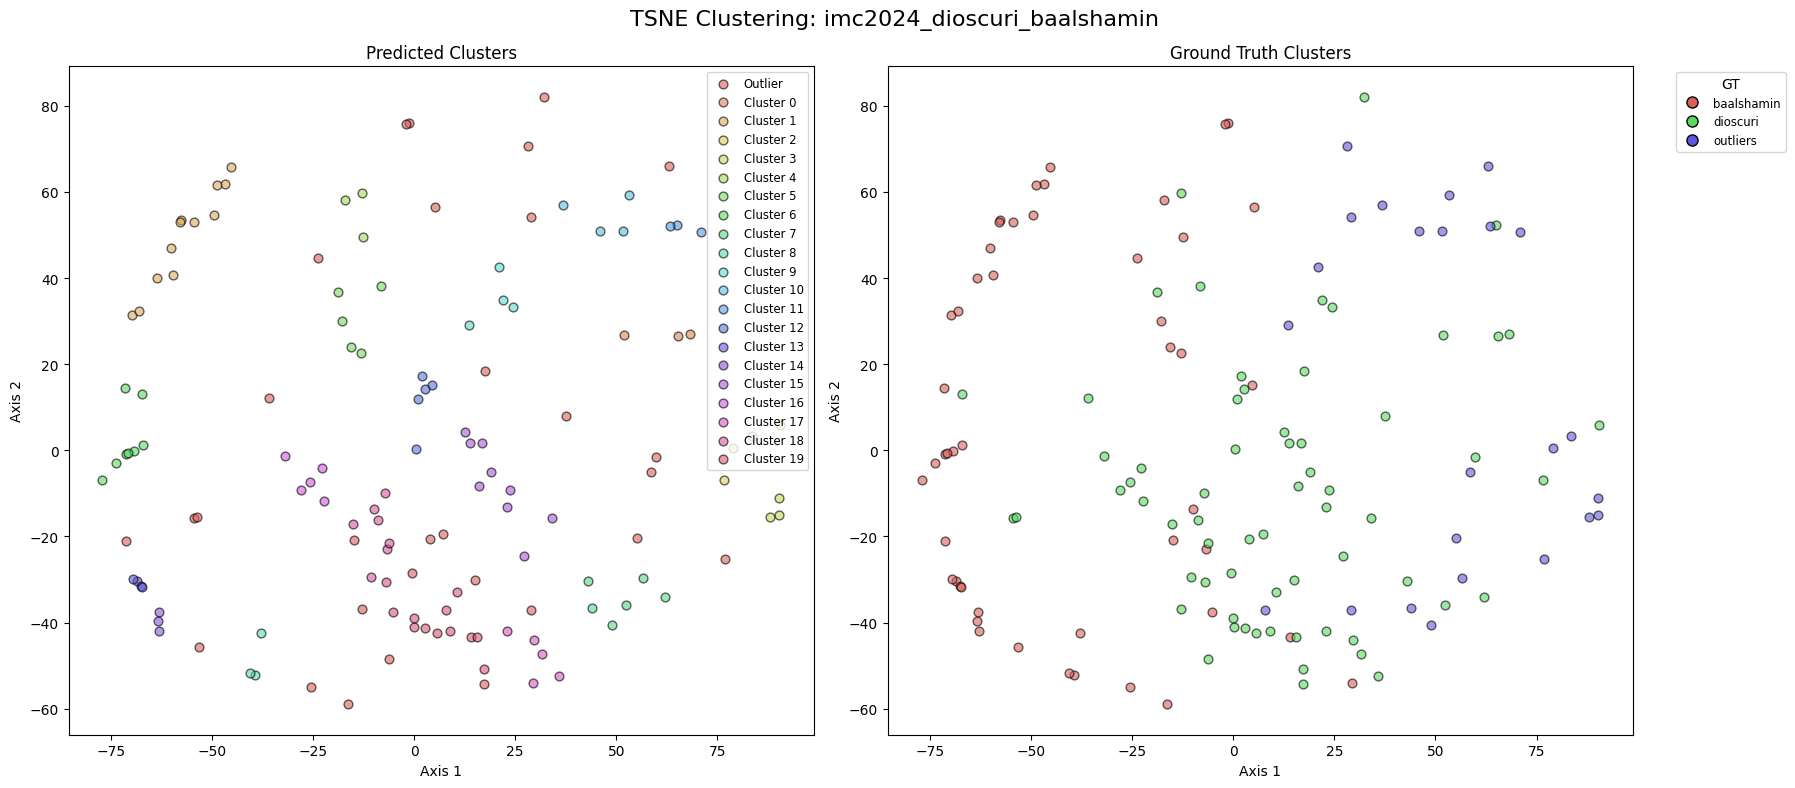

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_lizard_pond, Silhouette Score: 0.2383


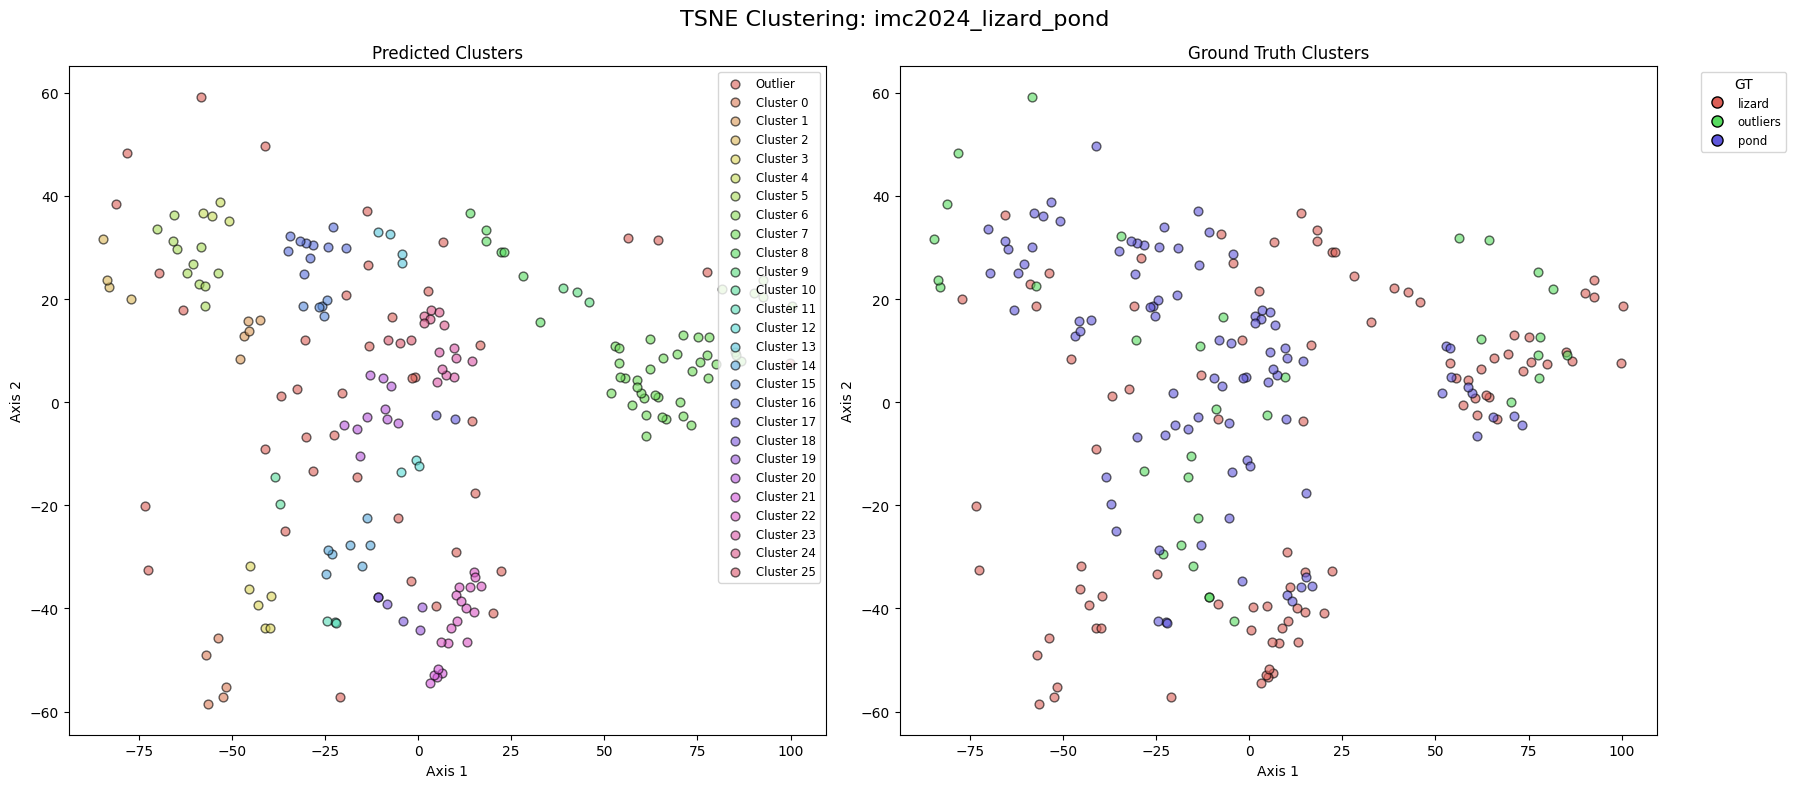

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_piazzasanmarco_grandplace, Silhouette Score: 0.1648


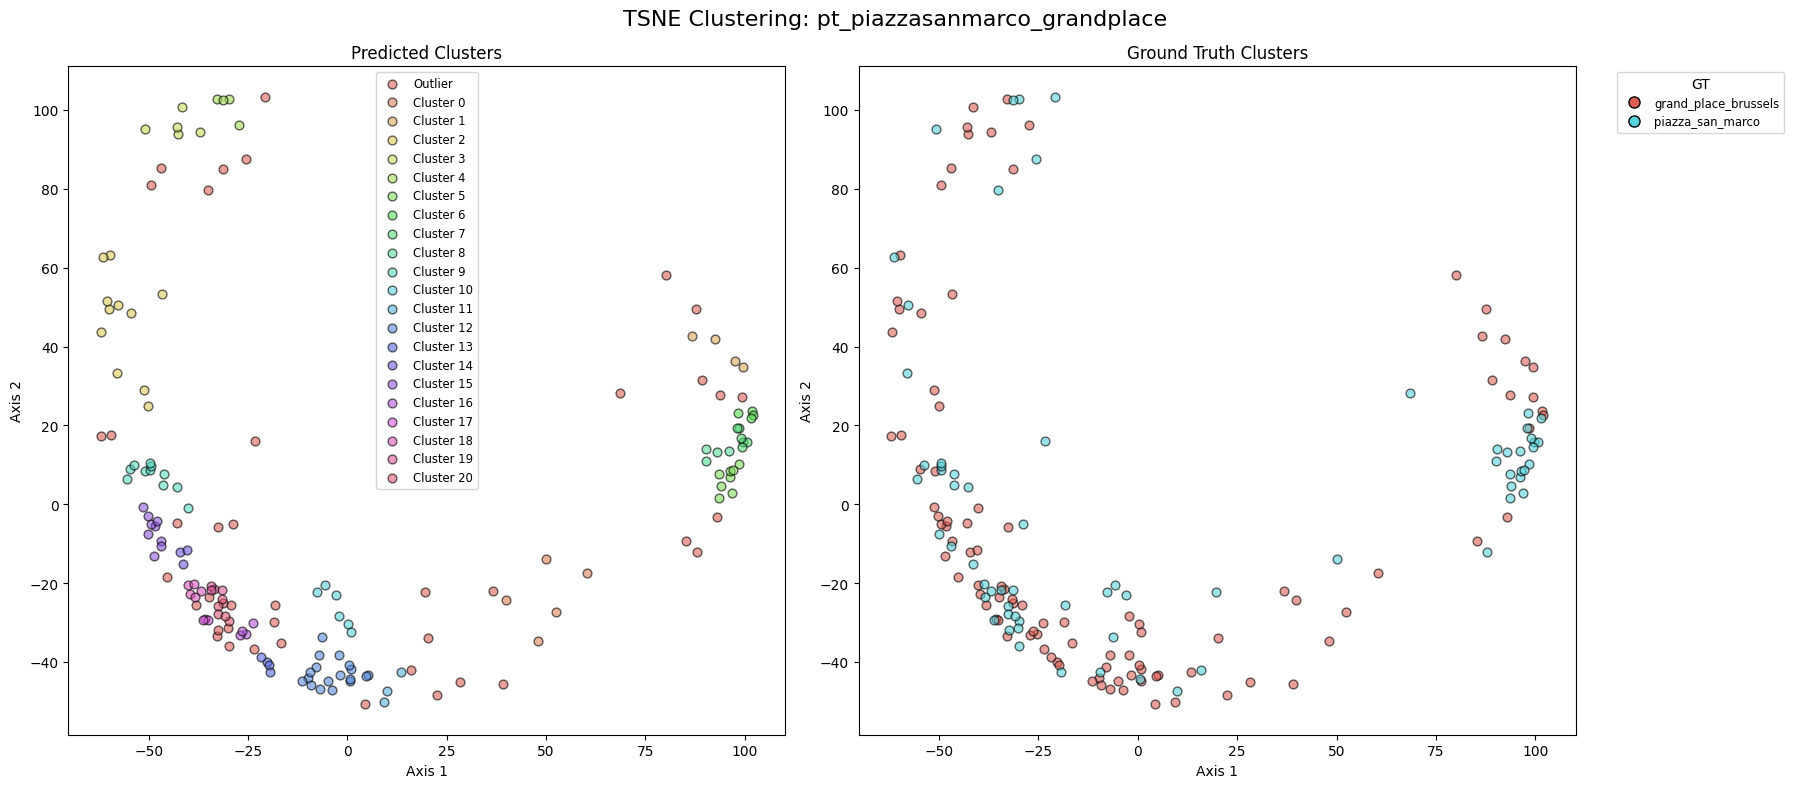

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_sacrecoeur_trevi_tajmahal, Silhouette Score: 0.0871


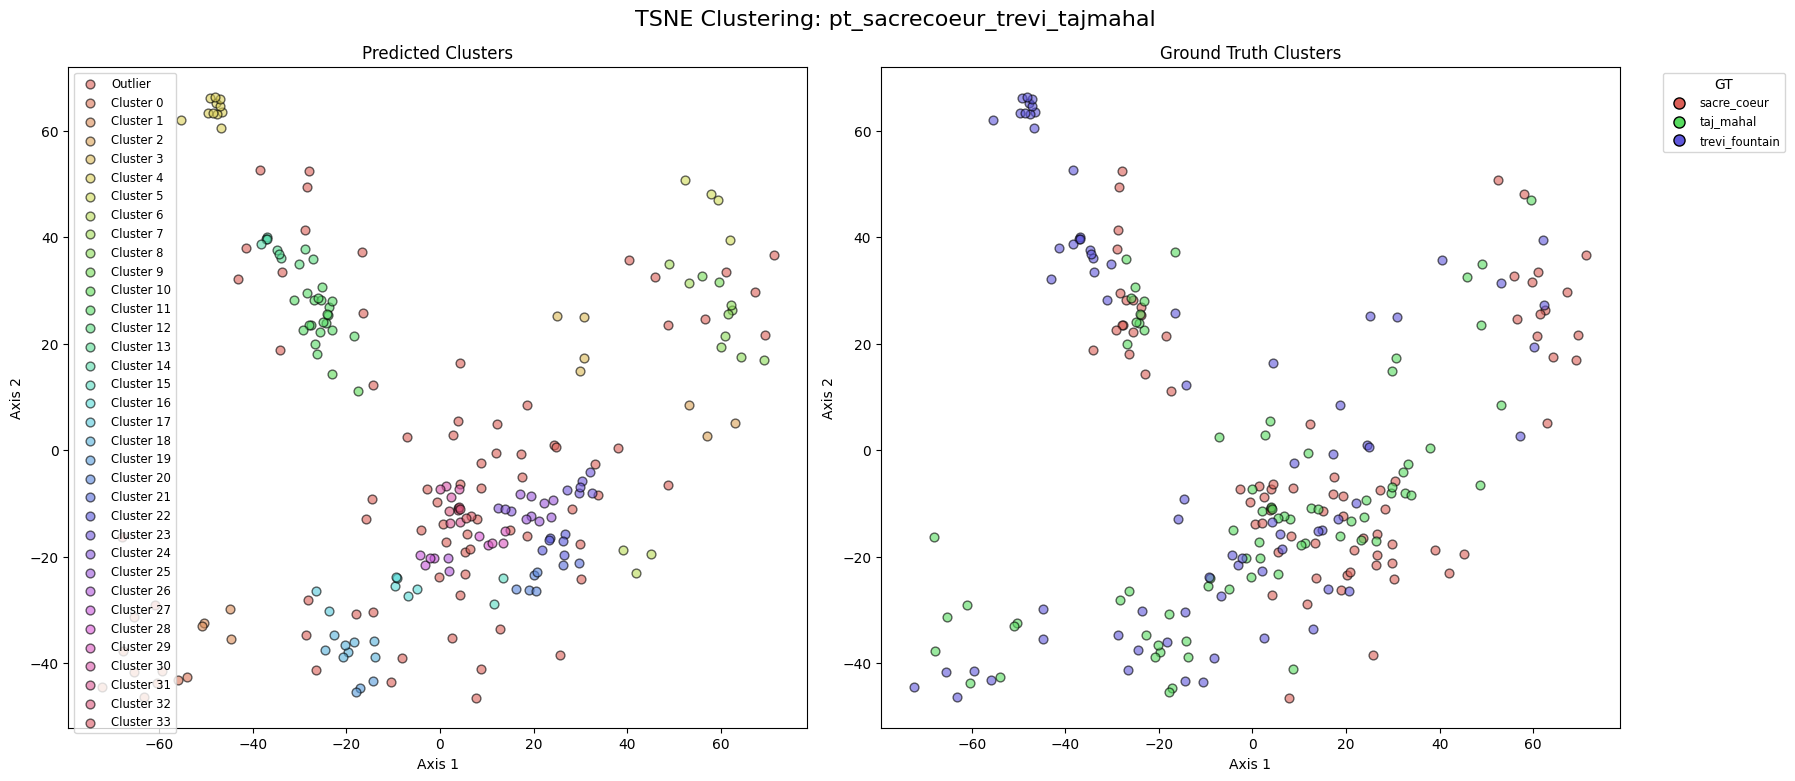

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: fbk_vineyard, Silhouette Score: 0.5350


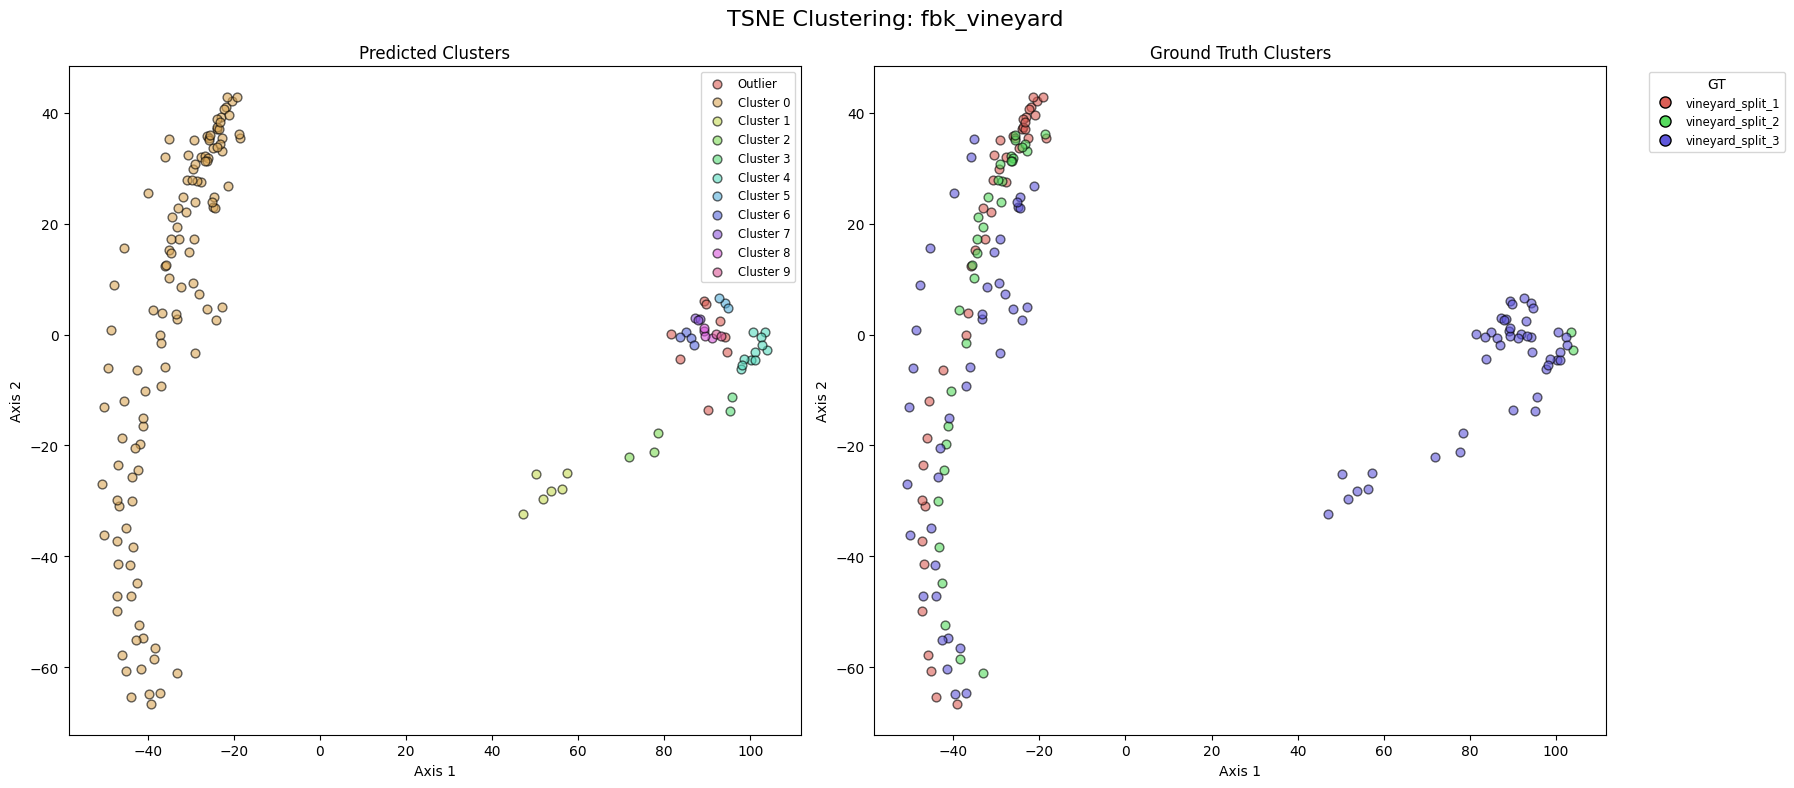

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: ETs, Silhouette Score: 0.6628


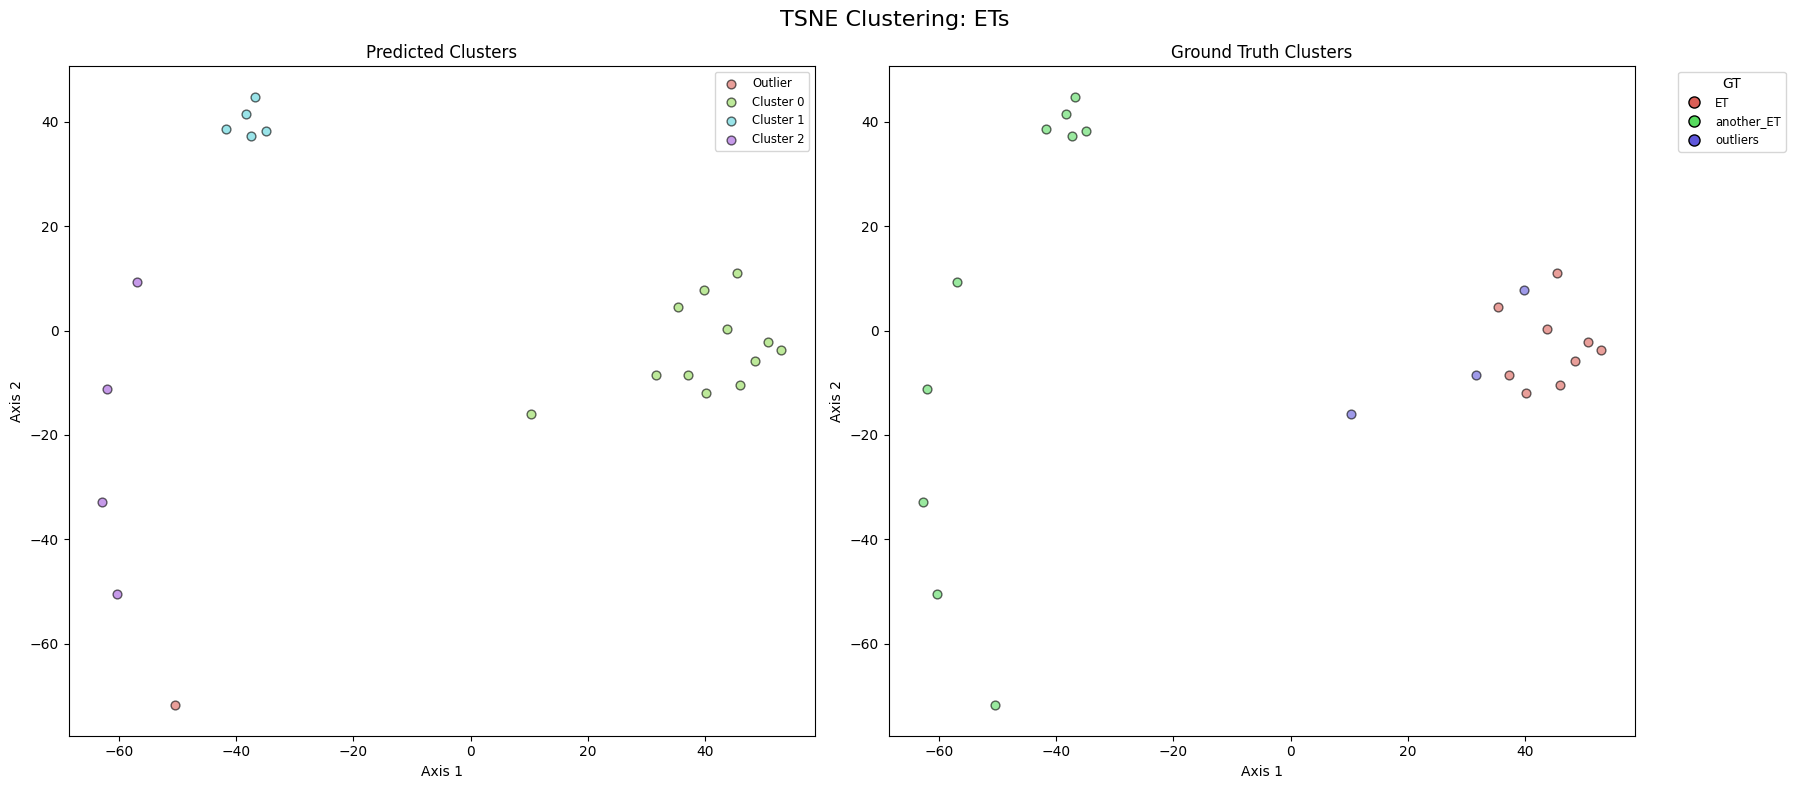

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: stairs, Silhouette Score: 0.0995


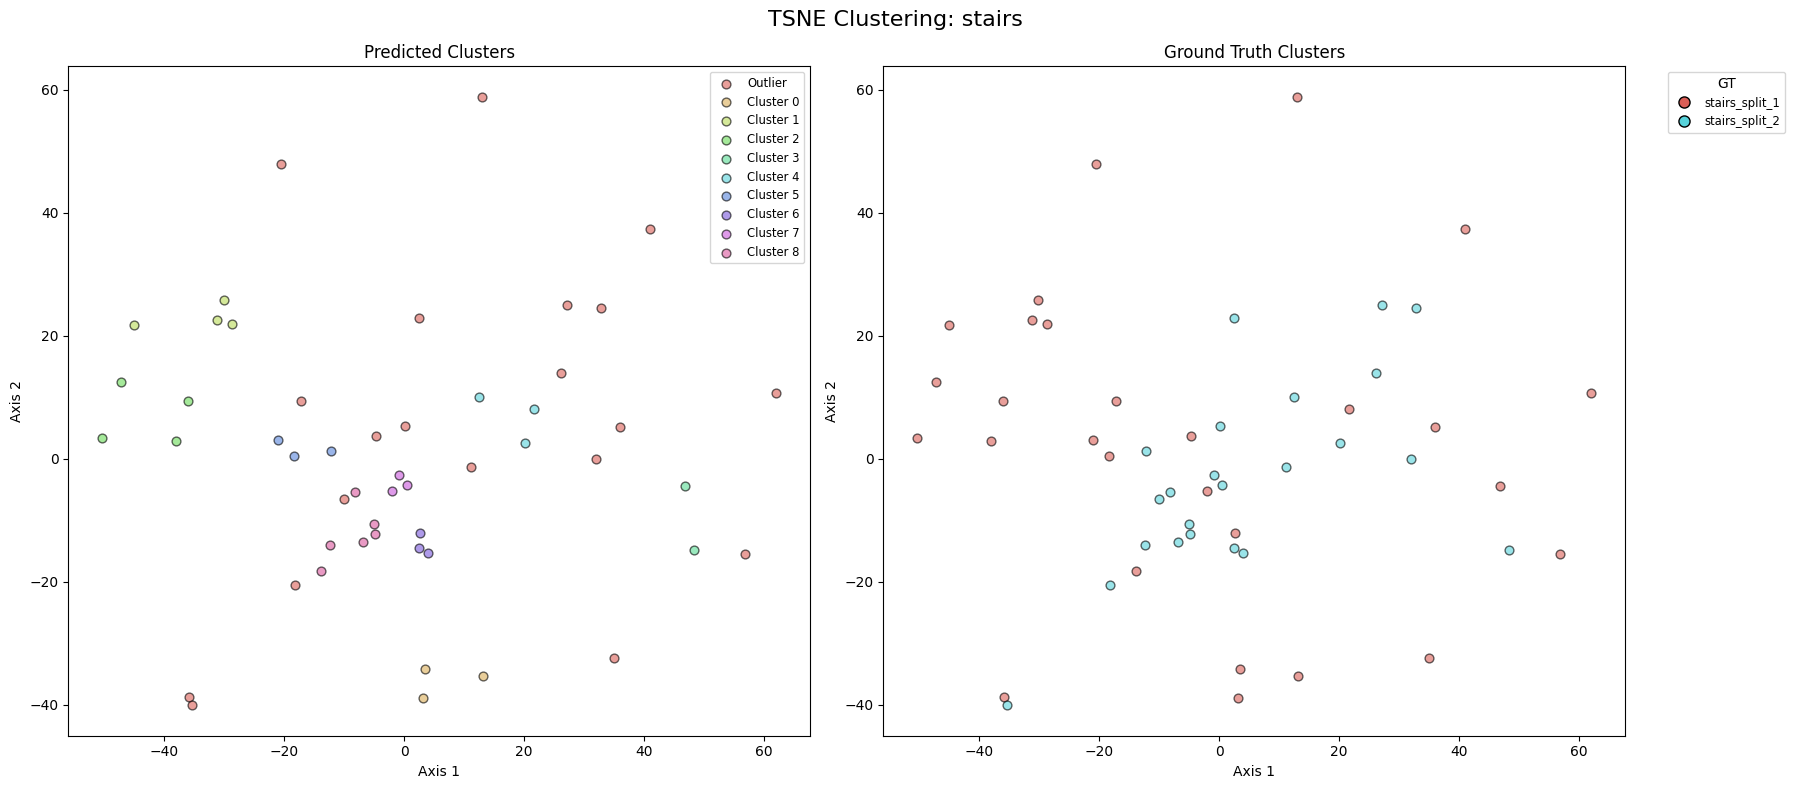

In [ ]:
for dataset_name, image_features in all_vectors.items():
    # Step 1: t-SNE on features
    features_2d = features.extraction.feature_reducer(
            algorithm="PCA",
            features=np.vstack(register_token_pooling_function(image_features)),
            n_components=2,
            random_state=42,
            # perplexity=15,
        )

    # Step 2: Run HDBSCAN or any clustering on 2D features
    cluster_labels = features.clustering.dino_clusterer(
            algorithm="HDBSCAN",
            features=features_2d,
            scaler=None,
            min_cluster_size=2,
        )
    silhouette_avg = silhouette_score(features_2d, cluster_labels)
    print(f"Dataset: {dataset_name}, Silhouette Score: {silhouette_avg:.4f}")

    visualize_clusters_2d(
        features_2d,
        cluster_labels,
        all_label_names,
        algorithm="TSNE",
    )

### Patch Pooling

In [ ]:
def patch_pooling(x):
    return np.mean([image_feature[5:, :] for image_feature in x], axis=1)

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2023_theather_imc2024_church, Silhouette Score: 0.5495


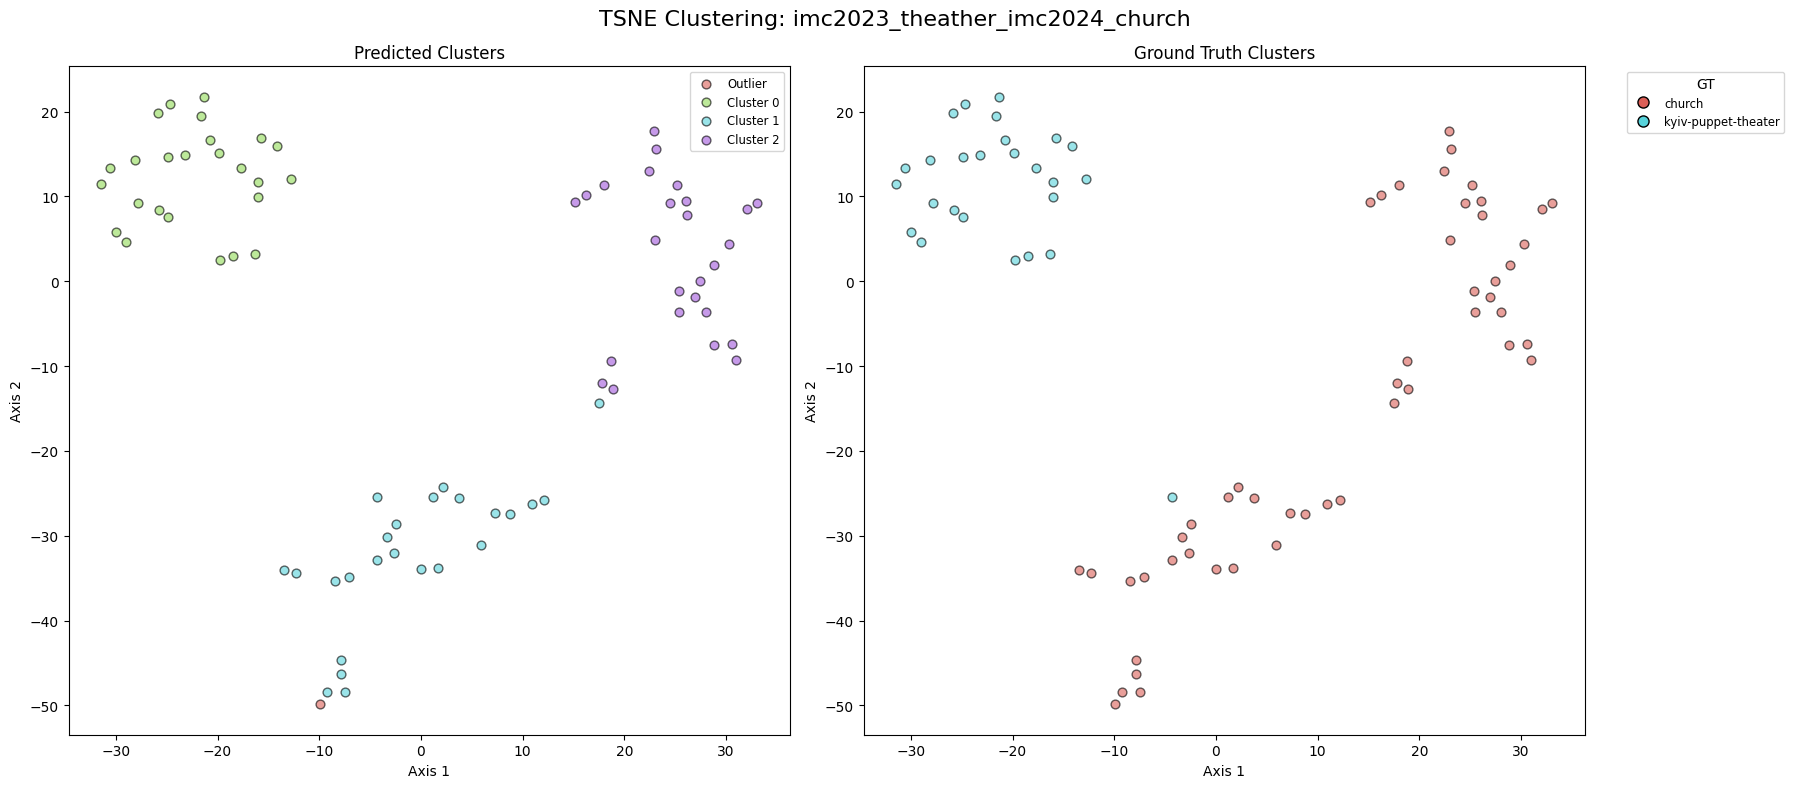

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_dioscuri_baalshamin, Silhouette Score: 0.6735


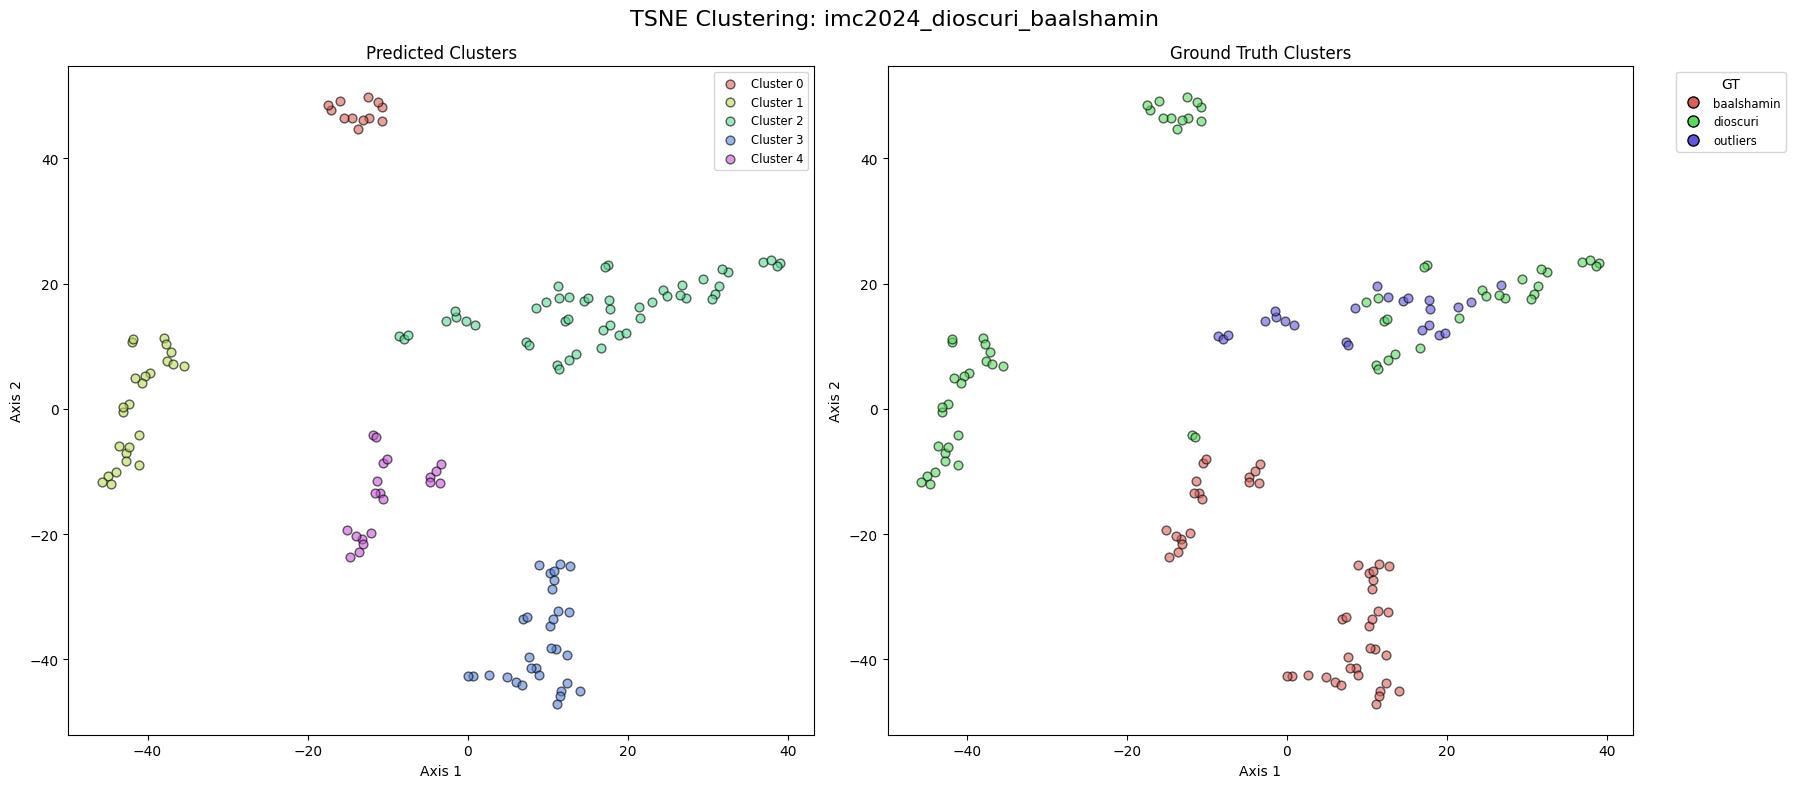

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: imc2024_lizard_pond, Silhouette Score: 0.5732


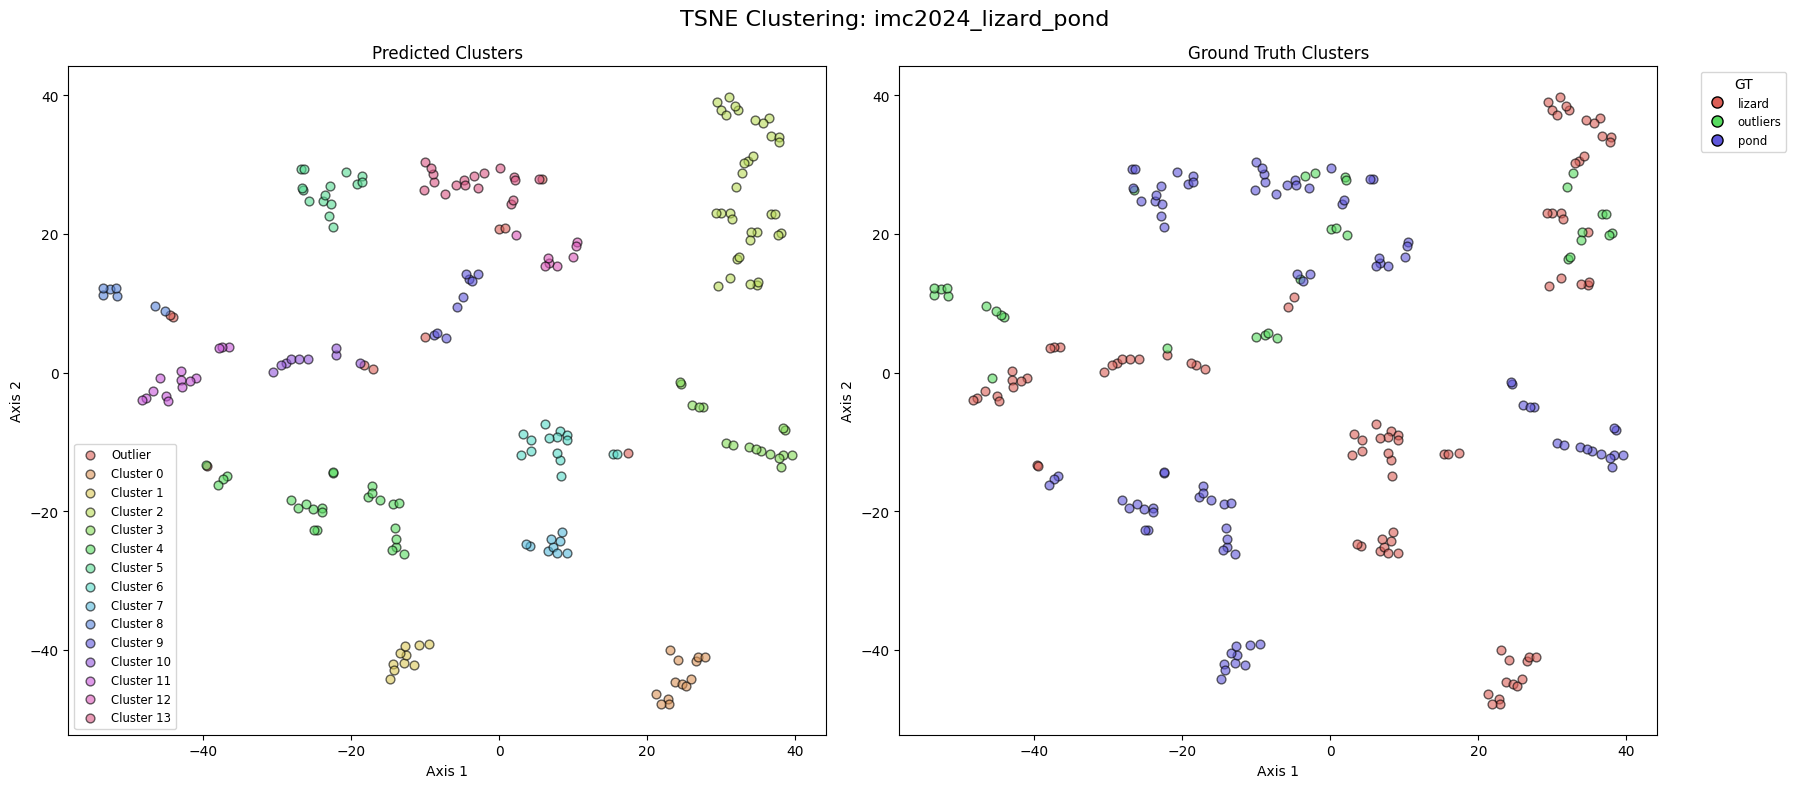

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_piazzasanmarco_grandplace, Silhouette Score: 0.5077


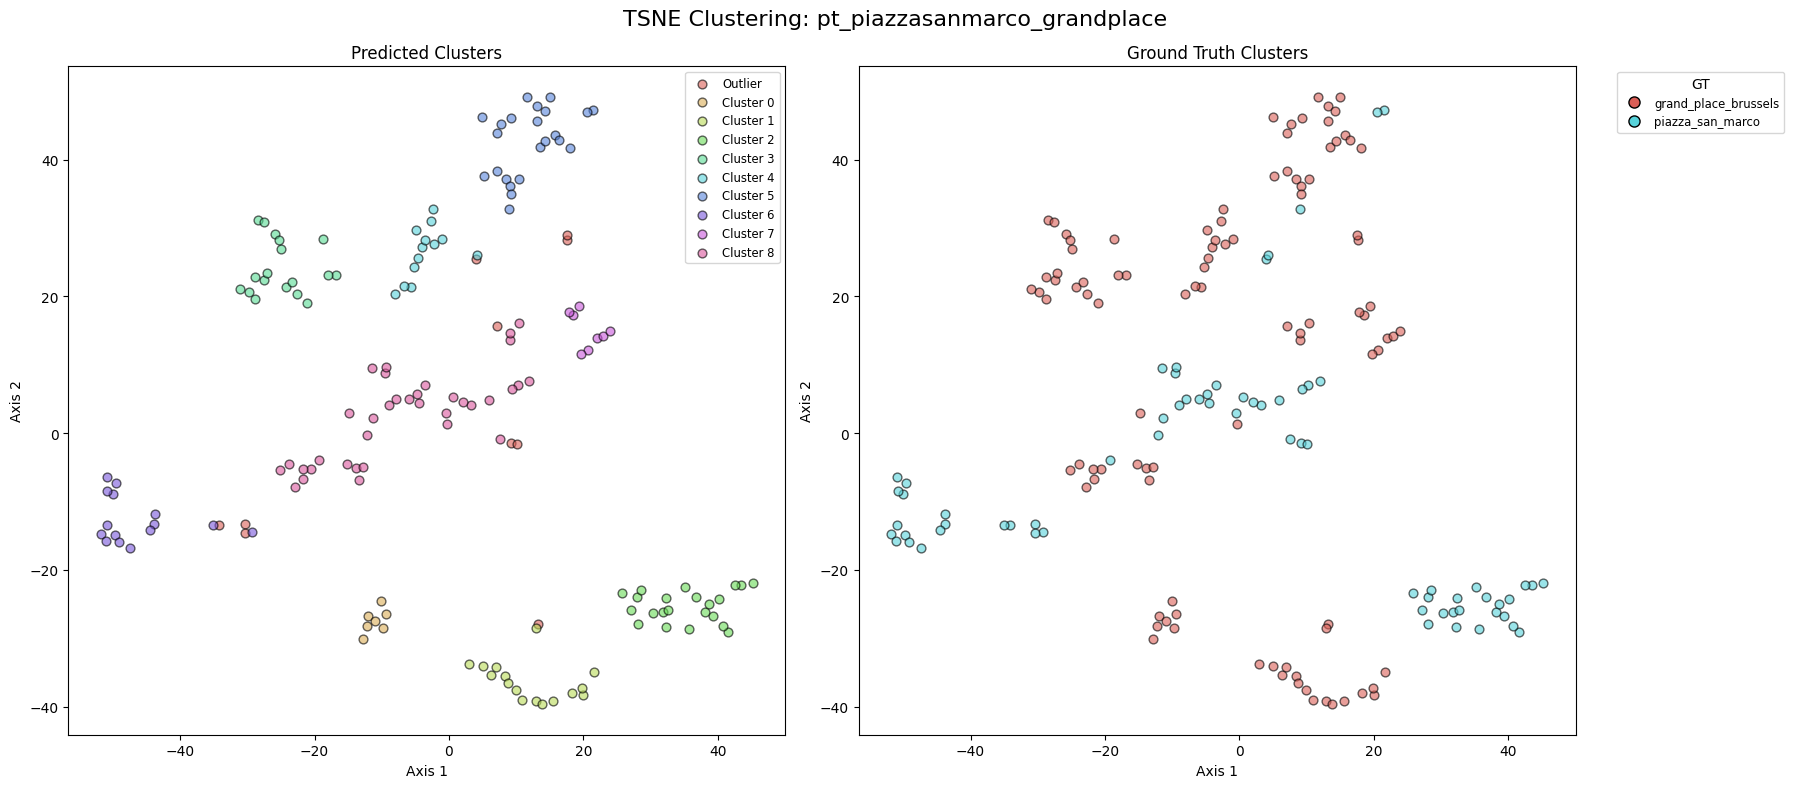

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: pt_sacrecoeur_trevi_tajmahal, Silhouette Score: 0.6570


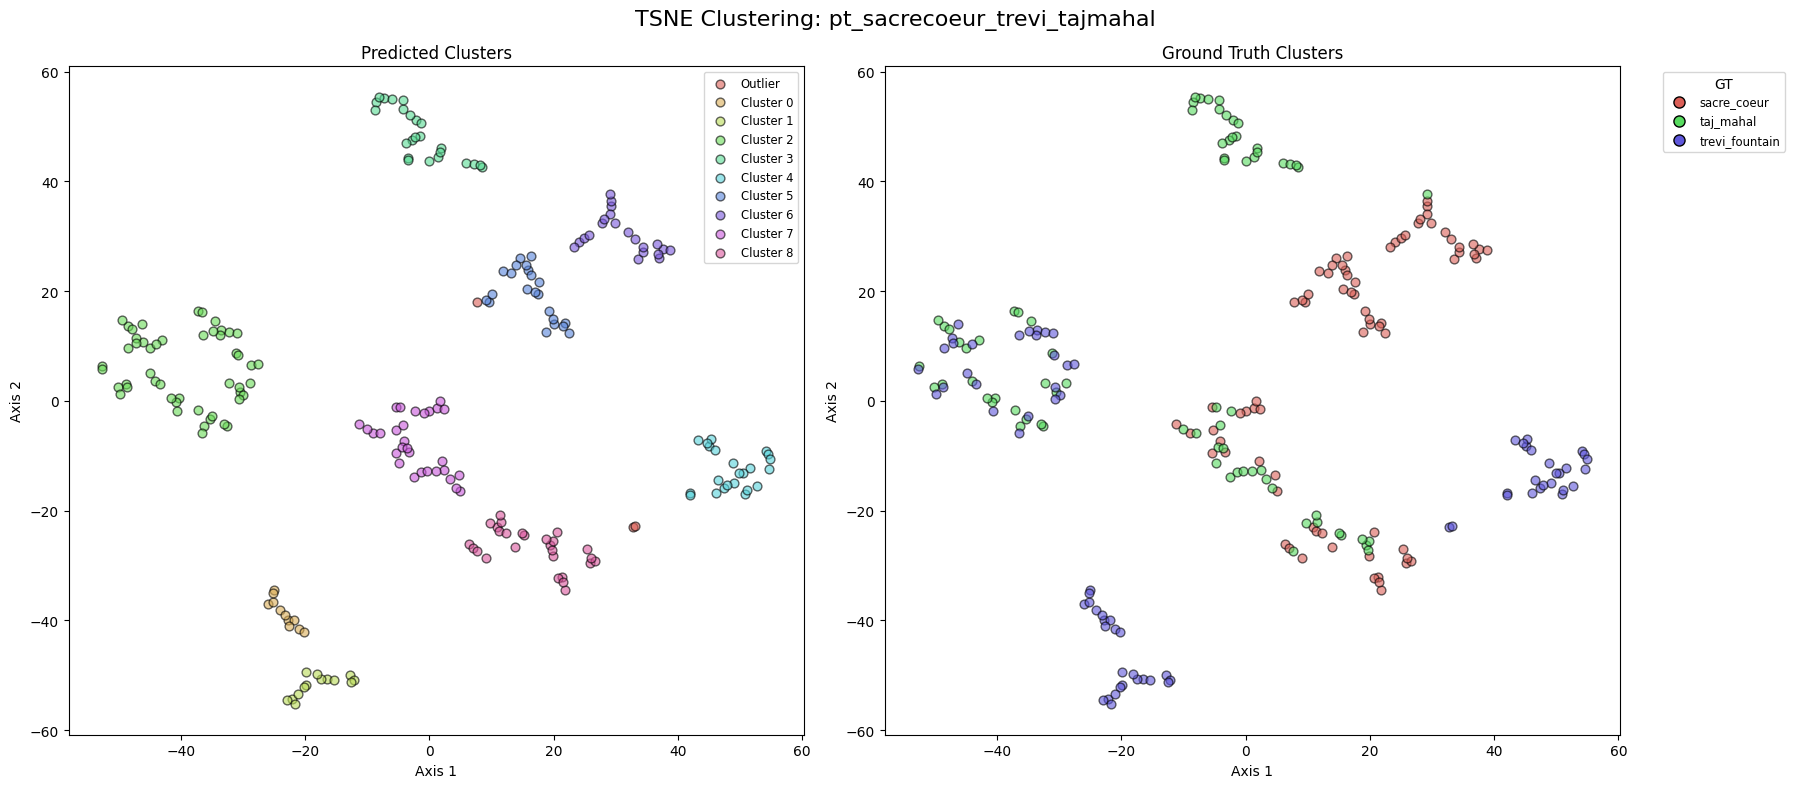

/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Dataset: fbk_vineyard, Silhouette Score: 0.6815


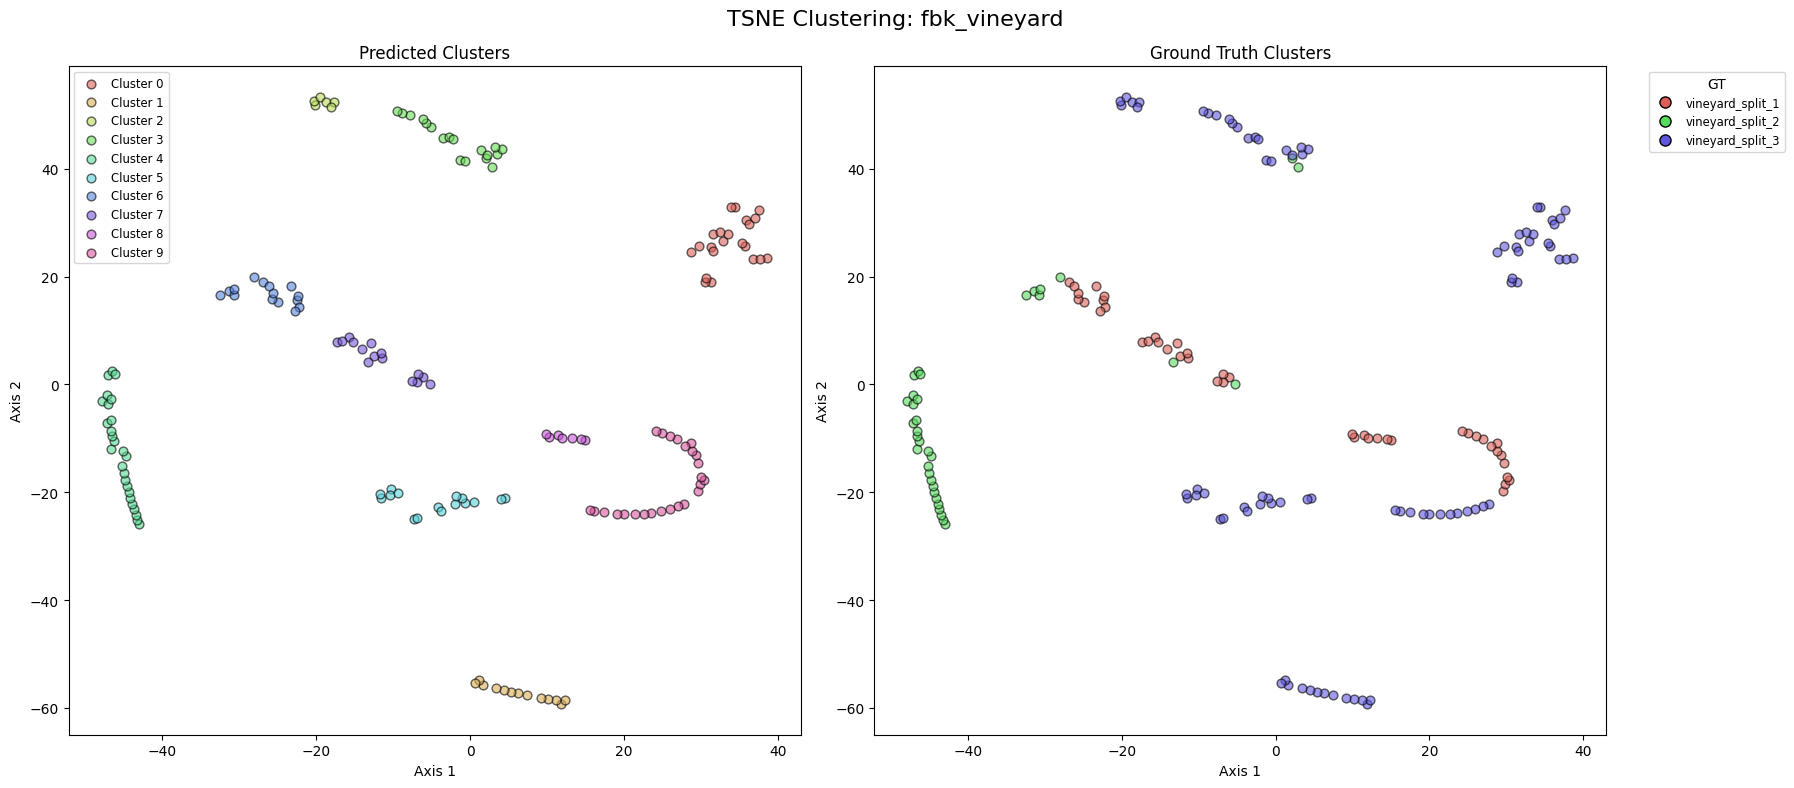

Dataset: ETs, Silhouette Score: 0.8900


/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


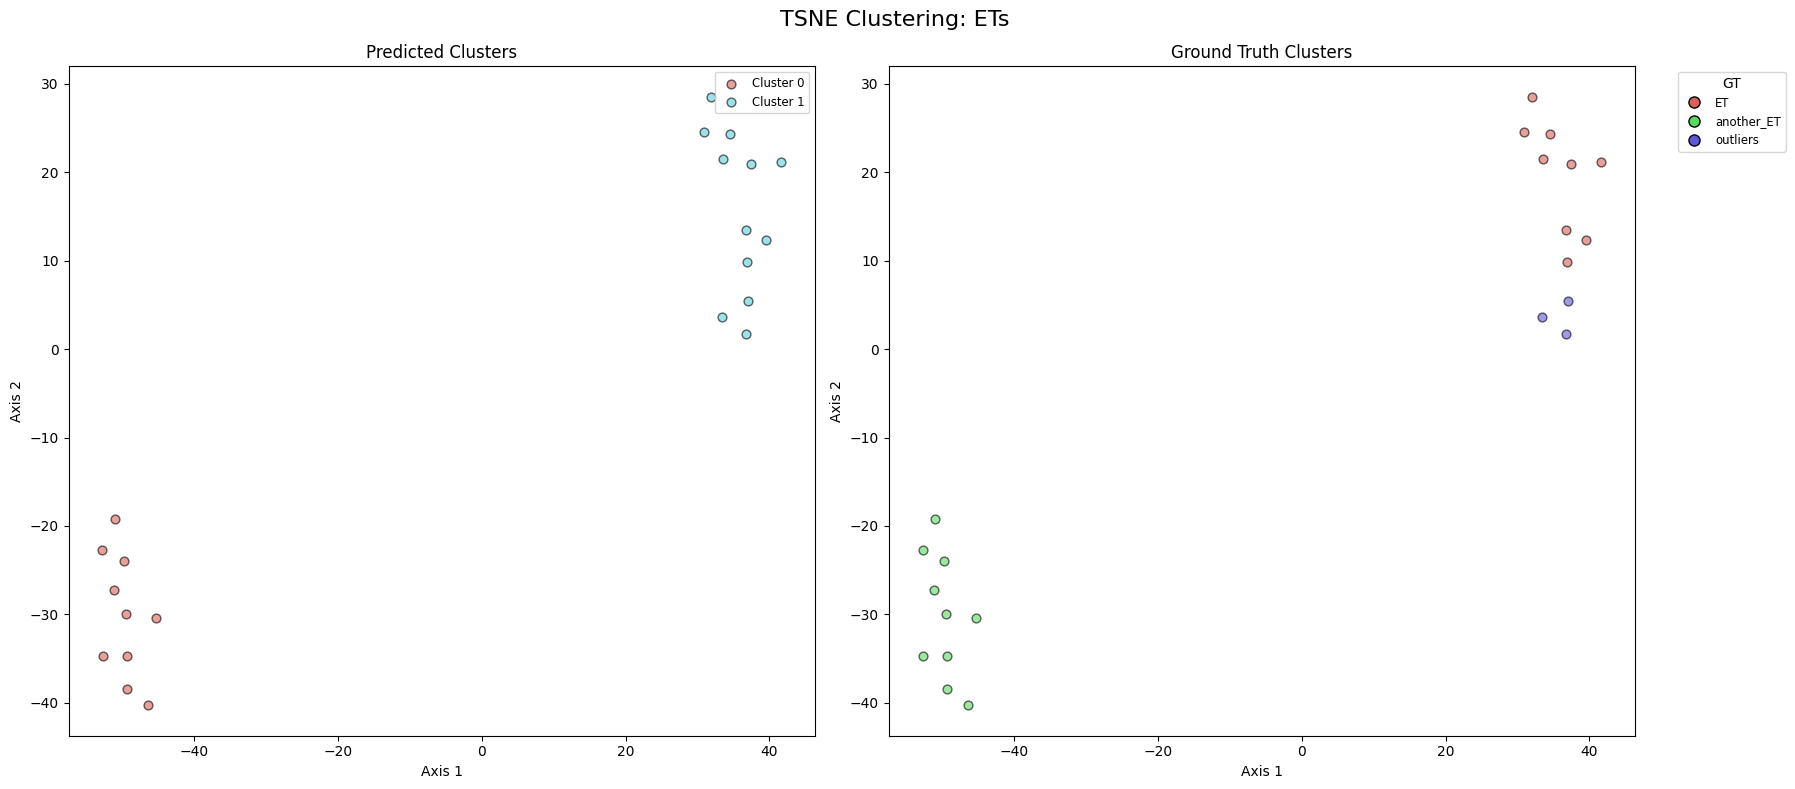

Dataset: stairs, Silhouette Score: 0.5396


/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/farrosalferro/miniconda3/envs/it1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


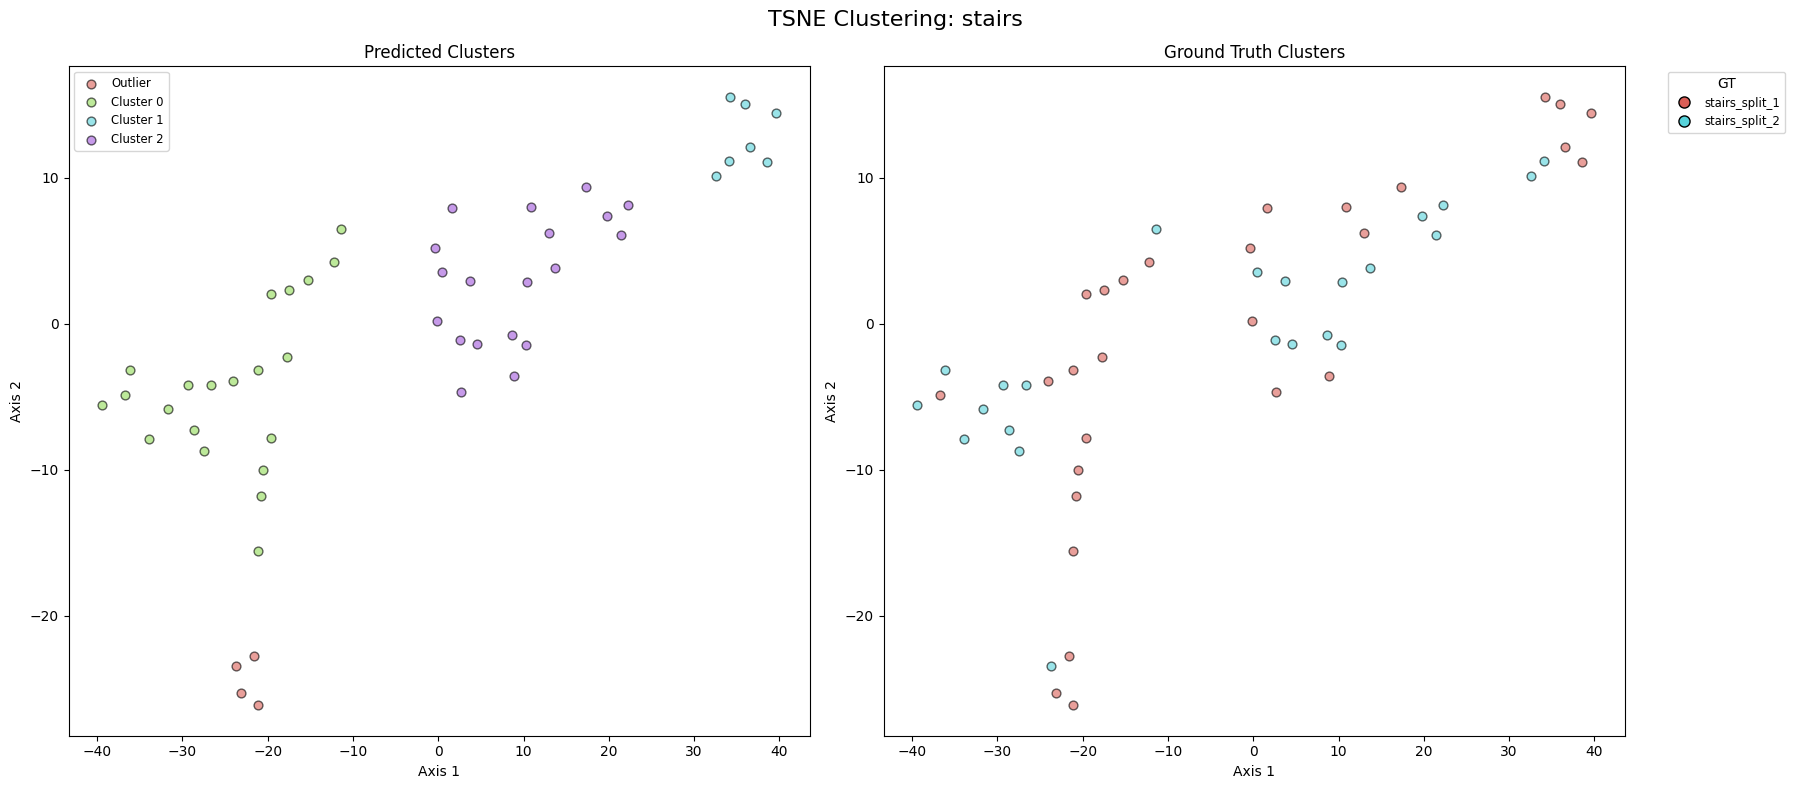

In [ ]:
for dataset_name, image_features in all_vectors.items():
    # Step 1: t-SNE on features
    features_2d = features.extraction.feature_reducer(
            algorithm="TSNE",
            features=np.vstack(patch_pooling(image_features)),
            n_components=2,
            random_state=42,
            perplexity=5,
        )

    # Step 2: Run HDBSCAN or any clustering on 2D features
    cluster_labels = features.clustering.dino_clusterer(
            algorithm="HDBSCAN",
            features=features_2d,
            scaler=None,
            min_cluster_size=5,
        )
    silhouette_avg = silhouette_score(features_2d, cluster_labels)
    print(f"Dataset: {dataset_name}, Silhouette Score: {silhouette_avg:.4f}")

    visualize_clusters_2d(
        features_2d,
        cluster_labels,
        all_label_names,
        algorithm="TSNE",
    )

### Silhouette Score
Since it's hard to predict based on visualization, we'll use Silhouette Score instead.

In [ ]:
pooling_functions = [
    first_register_token_pooling_function,
    camera_token_pooling_function,
    register_token_pooling_function,
    patch_pooling,
]
search_space = {"PCA": [10, 15, 20], "TSNE": [2, 3], "UMAP": [10, 15, 20]}
average_silhouette_scores = {}
for algorithm, dimensions in search_space.items():
    average_silhouette_scores[algorithm] = {}
    for dimension in dimensions:
        average_silhouette_scores[algorithm][dimension] = {}
        for pooling_function in pooling_functions:
            silhouette_scores = []
            for dataset_name, image_features in all_vectors.items():
                # Step 1: t-SNE on features
                if algorithm == "TSNE":
                    extracted_features = features.extraction.feature_reducer(
                            algorithm=algorithm,
                            features=np.vstack(pooling_function(image_features)),
                            n_components=dimension,
                            random_state=42,
                            perplexity=15,
                        )
                else:   # PCA or UMAP
                    extracted_features = features.extraction.feature_reducer(
                            algorithm=algorithm,
                            features=np.vstack(pooling_function(image_features)),
                            n_components=dimension,
                            random_state=42,
                        )

                # Step 2: Run HDBSCAN or any clustering on 2D features
                cluster_labels = features.clustering.dino_clusterer(
                        algorithm="HDBSCAN",
                        features=extracted_features,
                        scaler=None,
                        min_cluster_size=2,
                    )
                try:
                    silhouette_avg = silhouette_score(extracted_features, cluster_labels)
                    silhouette_scores.append(silhouette_avg)
                except ValueError as e:
                    print(f"Error calculating silhouette score for {dataset_name} with {algorithm}: {e}")
                    continue
            average_silhouette_scores[algorithm][dimension][pooling_function.__name__] = np.mean(silhouette_scores)
            print(f"Average Silhouette Score for {dimension} - {algorithm} - {pooling_function.__name__}: {np.mean(silhouette_scores):.4f}")

In [ ]:
average_silhouette_scores

{'PCA': {10: {'first_register_token_pooling_function': 0.16267723,
   'camera_token_pooling_function': 0.23118535,
   'register_token_pooling_function': 0.19302699,
   'patch_pooling': 0.2969415},
  15: {'first_register_token_pooling_function': 0.20385876,
   'camera_token_pooling_function': 0.20721707,
   'register_token_pooling_function': 0.2040875,
   'patch_pooling': 0.28127658},
  20: {'first_register_token_pooling_function': 0.18867142,
   'camera_token_pooling_function': 0.19675502,
   'register_token_pooling_function': 0.2198925,
   'patch_pooling': 0.27399746}},
 'TSNE': {2: {'first_register_token_pooling_function': 0.45247683,
   'camera_token_pooling_function': 0.4778729,
   'register_token_pooling_function': 0.4227084,
   'patch_pooling': 0.47739336},
  3: {'first_register_token_pooling_function': 0.17660393,
   'camera_token_pooling_function': 0.2478833,
   'register_token_pooling_function': 0.17156132,
   'patch_pooling': 0.1986399}},
 'UMAP': {10: {'first_register_token_